In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
bolTrainagain = False # will try to load data if false 

In [3]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=3
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 3 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
# needs treshold  3 QuatreCamins, 2 SantBoi,  7 Mollet 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  3516.6577380952117
Friday area:  3082.0952380952285
Weekend area:  523.6141262509632
Weekday maximum:  144.64285714285714
Friday maximum:  140.71428571428572
Weekend maximum:  26.775981524249424


## MATHEMATICAL MODEL - CDF Subtraction

In [4]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

#parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

if not(bolTrainagain):
    try:
        with open('data/'+current_parking+'_modelFitTH.pkl','rb') as f:  # Python 3: open(..., 'rb')
            [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
             errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
            f.close()
    except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
        print('no saved data: recalcualting')
        bolTrainagain = True

if bolTrainagain:
    errors_wd = np.ones(np.shape(training_weekdays_norm))

    parameters_tn_th_ind = np.array([.2 ,.05,.7,.1] + [.8]*wd_length)

    optimal_params_weekdaytn = minimize(model_tn_th_ind_max, 
                                    parameters_tn_th_ind, 
                                    args=(training_weekdays_norm,training_weekdays_isfull,errors_wd),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})


In [5]:
var_weekdaytn_time = np.mean(errors_wd)
#var_weekdaytn = optimal_params_weekdaytn.fun/np.size(training_weekdays_norm)
stdv_weekdaytn=math.sqrt(var_weekdaytn_time)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
#print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.05425



In [6]:
optimal_params_weekdaytn

 final_simplex: (array([[0.31383963, 0.03621748, 0.80902433, ..., 0.7261689 , 0.73093133,
        0.71026415],
       [0.31383962, 0.03621743, 0.80902429, ..., 0.72616862, 0.73093135,
        0.71026431],
       [0.31383961, 0.03621745, 0.80902433, ..., 0.72616875, 0.73093115,
        0.7102641 ],
       ...,
       [0.31383963, 0.03621744, 0.80902434, ..., 0.72616874, 0.73093142,
        0.71026423],
       [0.31383962, 0.03621747, 0.80902436, ..., 0.72616904, 0.73093146,
        0.71026411],
       [0.31383964, 0.03621744, 0.80902432, ..., 0.72616875, 0.73093142,
        0.71026431]]), array([3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
   

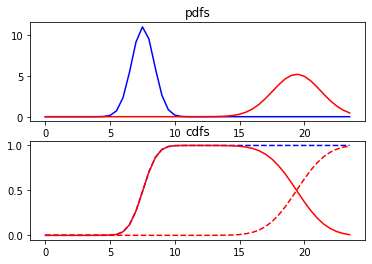

In [7]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [8]:
optimal_params_weekdayth=np.mean(optimal_params_weekdaytn.x[4:])

In [9]:
optimal_params_weekdayth

0.795802575658487

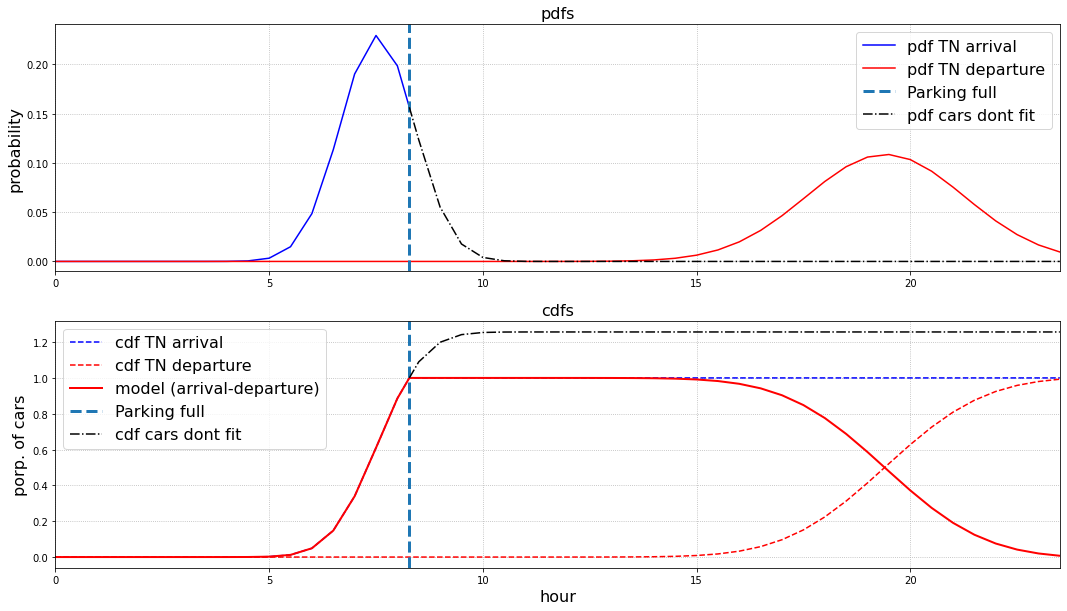

In [10]:
fid=plot_model_tn_thDisc(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],
              optimal_params_weekdaytn.x[3],optimal_params_weekdayth)
fid.savefig('Model_'+current_parking+'.pdf',bbox_inches='tight');

In [11]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.31383963, 0.03621748, 0.80902433, 0.0772256 , 0.76561431,
       0.62051281, 0.85422873, 0.86941477, 0.82320583, 0.87775692,
       0.92357488, 0.87157498, 0.8335844 , 0.83529347, 0.8482066 ,
       0.82297959, 0.83987068, 0.84802219, 0.80918356, 0.80282006,
       0.80040425, 0.79872722, 0.81020112, 0.80603411, 0.73694148,
       0.73420851, 0.7261689 , 0.72622504, 0.73035329, 0.7261689 ,
       0.73093133, 0.71026415])

In [12]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
prototype_math_arr_weekday=cdf1_wd
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
prototype_math_dep_weekday=cdf2_wd
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd#/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")
#plt.plot(time2, cdf1_wd_ap, label="Cummulative probability arrival approx")
#plt.plot(time2, cdf2_wd_ap, label="Cummulative probability departure approx")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


In [13]:
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])

ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdayth)
t_parking_full=np.interp(optimal_params_weekdayth,cdf1_wd,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)

tn1_wd_unmodifed=tn1_wd
tn1_wd=np.insert(tn1_wd,ix_parking_full,np.interp(t_parking_full,time2,tn1_wd))
tn1_wd_excees=tn1_wd.copy()
tn1_wd[ix_parking_full+1:] =0
tn1_wd_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_wd), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_wd), dtype=bool)
masktn1_excees[:ix_parking_full] =False

#tn1_wd[cdf1_wd>optimal_params_weekdayth] =0
#tn1_wd_excees[cdf1_wd<optimal_params_weekdayth] =0
cdf1_wd[cdf1_wd>optimal_params_weekdayth] = optimal_params_weekdayth
cdf1_wd_plot=np.insert(cdf1_wd,ix_parking_full,optimal_params_weekdayth)

cdf1_wd = cdf1_wd/optimal_params_weekdayth
cdf1_wd_plot = cdf1_wd_plot/optimal_params_weekdayth

cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
cdf2_wd_plot=np.insert(cdf2_wd,ix_parking_full,np.interp(t_parking_full,time2,cdf2_wd))
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
resta_wd_plot = np.array(cdf1_wd_plot) - np.array(cdf2_wd_plot)
prototype_math_weekday = resta_wd#/sum(resta_wd)
prototype_math_weekday_plot = resta_wd_plot#/sum(resta_wd)
#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2_th[masktn1], tn1_wd[masktn1]/sum(tn1_wd_unmodifed), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2_th, cdf1_wd_plot, label="Cummulative probability arrival")
#plt.plot(time2_th, cdf2_wd_plot, label="Cummulative probability departure")

#plt.plot(t_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
#plt.plot(time2_th[masktn1_excees], tn1_wd_excees[masktn1_excees]/sum(tn1_wd_unmodifed),'-.',
#         label="Excess Probability")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");

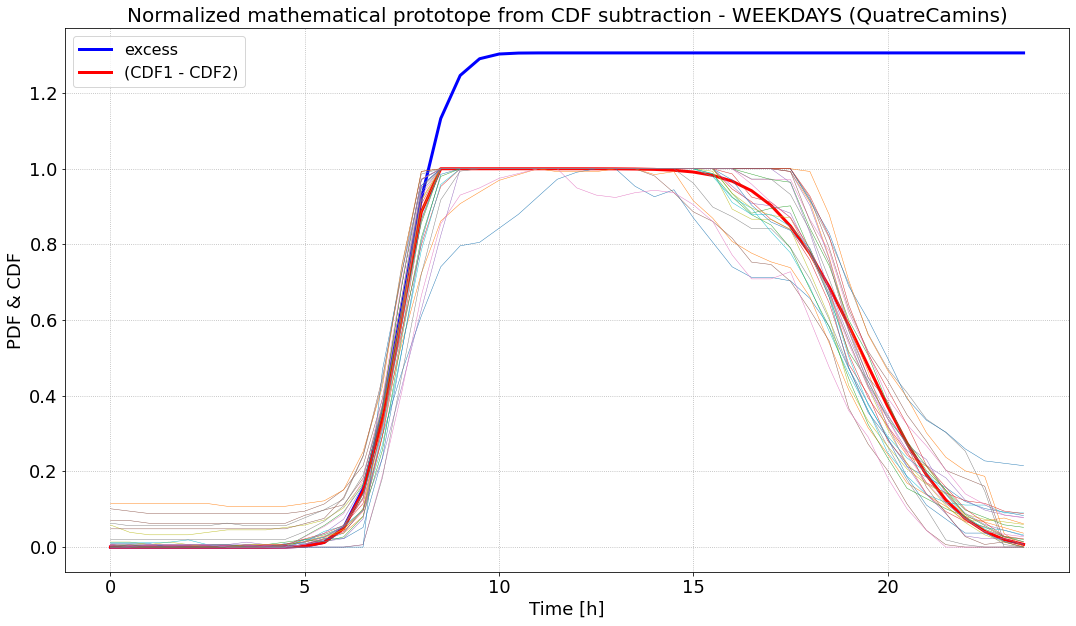

In [14]:
fig = plt.figure(figsize=(18,10))
plt.title("Normalized mathematical prototope from CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time2, prototype_math_arr_weekday/optimal_params_weekdaytn.x[4], linewidth=3, color='blue', label="excess")
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    plt.plot(time, training_weekdays_norm[i], linewidth=0.45)

plt.legend(fontsize=16, loc="upper left");

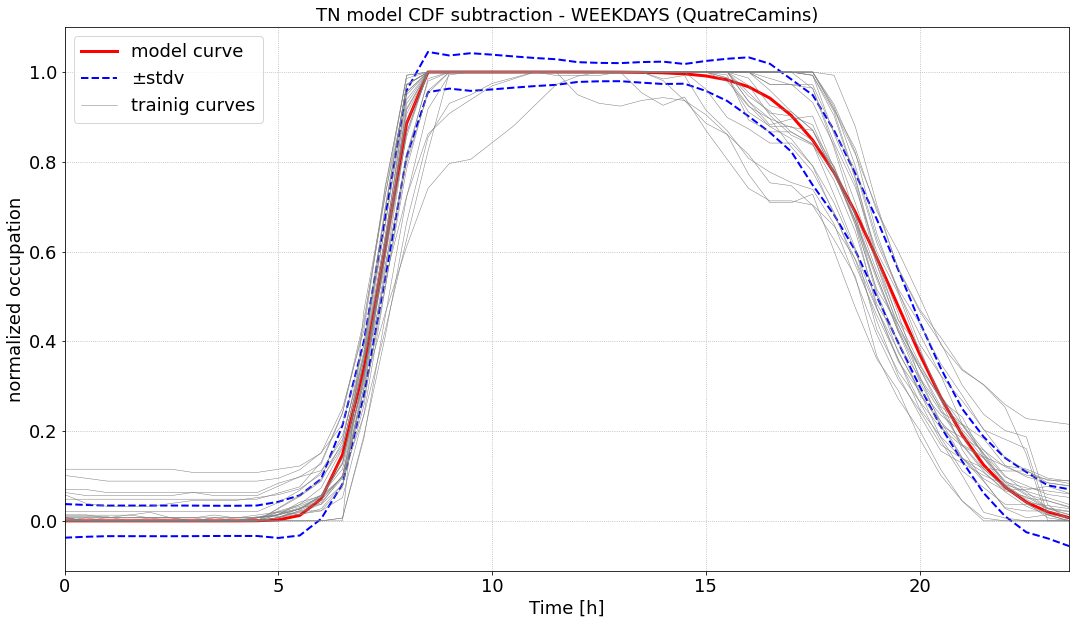

In [15]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

In [16]:
bol_plot_individual_fits = False
if bol_plot_individual_fits: 
    tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
    tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

    cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

    for ii in range(0,len(training_weekdays_norm)):
        idx_th=ii+4

        cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])


        dayisFull=training_weekdays_isfull[ii]
        if dayisFull:
            print(optimal_params_weekdaytn.x[idx_th])

            ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdaytn.x[idx_th])
            time_parking_full= 0.5*ix_parking_full
            str_parking_full= f'{int(time_parking_full):02.0f}:{int((time_parking_full-int(time_parking_full))*60):02.0f}h'

            print('Parking full        = '+str_parking_full)
            tn1_wd[cdf1_wd>optimal_params_weekdaytn.x[idx_th]] =0
            cdf1_wd[cdf1_wd>optimal_params_weekdaytn.x[idx_th]] = optimal_params_weekdaytn.x[idx_th]
            cdf1_wd = cdf1_wd/optimal_params_weekdaytn.x[idx_th]
        else:
            ix_parking_full=0
        resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
        prototype_math_weekday = resta_wd#/sum(resta_wd)
        fig = plt.figure(figsize=(18,10))
        fig.suptitle("Normalized mathematical prototope from CDF subtraction - weekdayS ("+current_parking+")", fontsize=20)
        if dayisFull:
            plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full "+str_parking_full)
        plt.grid(linestyle='dotted')
        plt.xlabel("Time [h]", fontsize=18)
        plt.ylabel("PDF & CDF", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.plot(time, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
        #for i in range(0,len(training_weekdays_norm)):
        plt.plot(time, training_weekdays_norm[ii], linewidth=0.45)
        plt.legend(fontsize=16);

### FRIDAYS

In [17]:
if bolTrainagain:
    errors_fr = np.ones(np.shape(training_fridays_norm))

    parameters_tn_th_ind = np.array([.2 ,.05,.7,.1] + [.8]*f_length)
    optimal_params_fridaytn = minimize(model_tn_th_ind_max, 
                                    parameters_tn_th_ind, 
                                    args=(training_fridays_norm,training_fridays_isfull,errors_fr),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})



In [18]:
var_fridaytn = np.mean(errors_fr)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors_fr,0))
#print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.05573



In [19]:
optimal_params_fridaytn

 final_simplex: (array([[0.32164844, 0.03851972, 0.77068313, 0.11790025, 0.68350776,
        0.82301888, 0.87377744, 0.68089001, 0.68089114, 0.68089001,
        0.69284511],
       [0.32164843, 0.03851971, 0.7706832 , 0.11790018, 0.68350732,
        0.82301856, 0.8737774 , 0.68089046, 0.68089159, 0.68089046,
        0.69284568],
       [0.32164842, 0.03851971, 0.77068317, 0.11790015, 0.68350747,
        0.82301872, 0.87377736, 0.6808905 , 0.68089163, 0.6808905 ,
        0.69284576],
       [0.32164844, 0.0385197 , 0.7706833 , 0.11790022, 0.68350703,
        0.82301821, 0.87377726, 0.68089068, 0.68089181, 0.68089068,
        0.69284601],
       [0.32164845, 0.03851972, 0.77068321, 0.1179001 , 0.68350696,
        0.82301841, 0.87377732, 0.68089087, 0.680892  , 0.68089087,
        0.69284595],
       [0.32164845, 0.03851971, 0.77068322, 0.11790025, 0.68350715,
        0.82301827, 0.87377769, 0.68089014, 0.68089127, 0.68089014,
        0.69284534],
       [0.3216484 , 0.03851971, 0.7706831

In [20]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [21]:
optimal_params_fridaytn.x[4:]

array([0.68350776, 0.82301888, 0.87377744, 0.68089001, 0.68089114,
       0.68089001, 0.69284511])

In [22]:
optimal_params_fridayth=np.mean(optimal_params_fridaytn.x[4:])

In [23]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta#/sum(resta)
#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_fri, label="CDF Slot occupied")
#plt.plot(time, cdf2_fri, label="CDF Slot free")
#plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
#plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

In [24]:
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
prototype_math_arr_friday=cdf1_fri.copy()

ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridayth)
t_parking_full=np.interp(optimal_params_fridayth,cdf1_fri,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)


tn1_fri_unmodifed=tn1_fri
tn1_fri=np.insert(tn1_fri,ix_parking_full,np.interp(t_parking_full,time2,tn1_fri))
tn1_fri_excees=tn1_fri.copy()
tn1_fri[ix_parking_full+1:] =0
tn1_fri_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_fri), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_fri), dtype=bool)
masktn1_excees[:ix_parking_full] =False

cdf1_fri[cdf1_fri>optimal_params_fridayth] = optimal_params_fridayth
cdf1_fri_plot=np.insert(cdf1_fri,ix_parking_full,optimal_params_fridayth)

cdf1_fri = cdf1_fri/optimal_params_fridayth
cdf1_fri_plot = cdf1_fri_plot/optimal_params_fridayth

cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])
cdf2_fri_plot=np.insert(cdf2_fri,ix_parking_full,np.interp(t_parking_full,time2,cdf2_fri))
prototype_math_dep_friday=cdf2_fri
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
resta_fri_plot = np.array(cdf1_fri_plot) - np.array(cdf2_fri_plot)
prototype_math_friday = resta_fri#/sum(resta_wd)
prototype_math_friday_plot = resta_fri_plot

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)

#plt.plot(time2_th[masktn1], tn1_fri[masktn1]/sum(tn1_fri_unmodifed), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.plot(time2_th, cdf1_fri_plot, label="Cummulative probability arrival")
#plt.plot(time2_th, cdf2_fri_plot, label="Cummulative probability departure")
#plt.plot(t_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
#plt.plot(time2_th[masktn1_excees], tn1_fri_excees[masktn1_excees]/sum(tn1_fri_unmodifed),'-.',
#         label="Excess Probability")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");

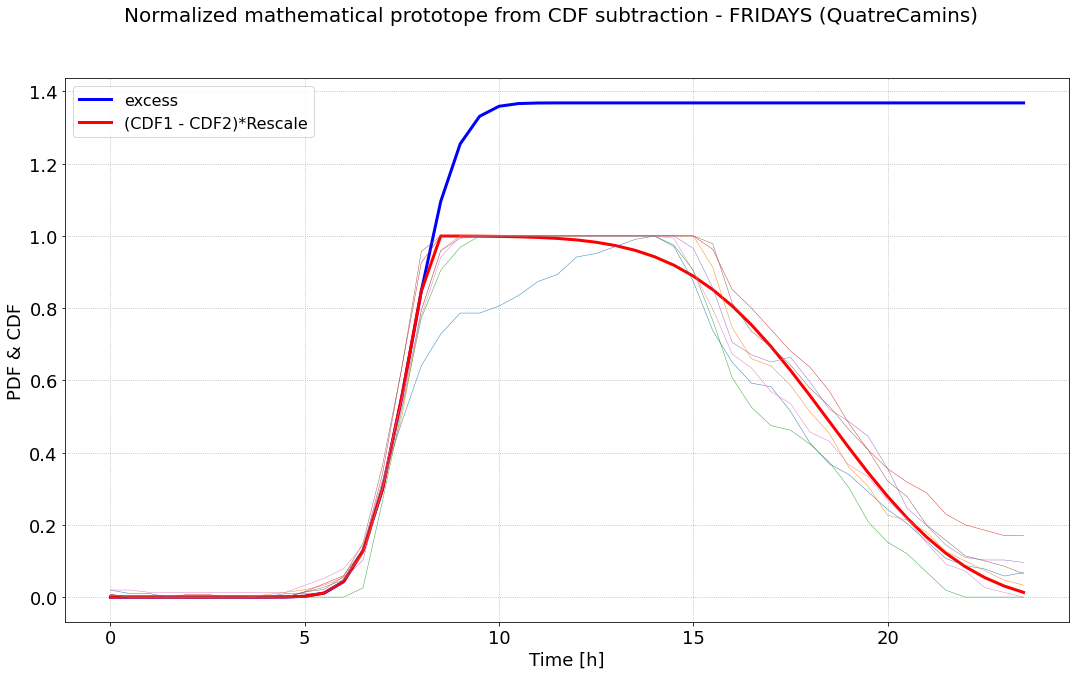

In [25]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time, prototype_math_arr_friday/optimal_params_fridayth, linewidth=3, color='blue', label="excess")
plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
for i in range(0,len(training_fridays_norm)):
    plt.plot(time, training_fridays_norm[i], linewidth=0.45)
plt.legend(fontsize=16);

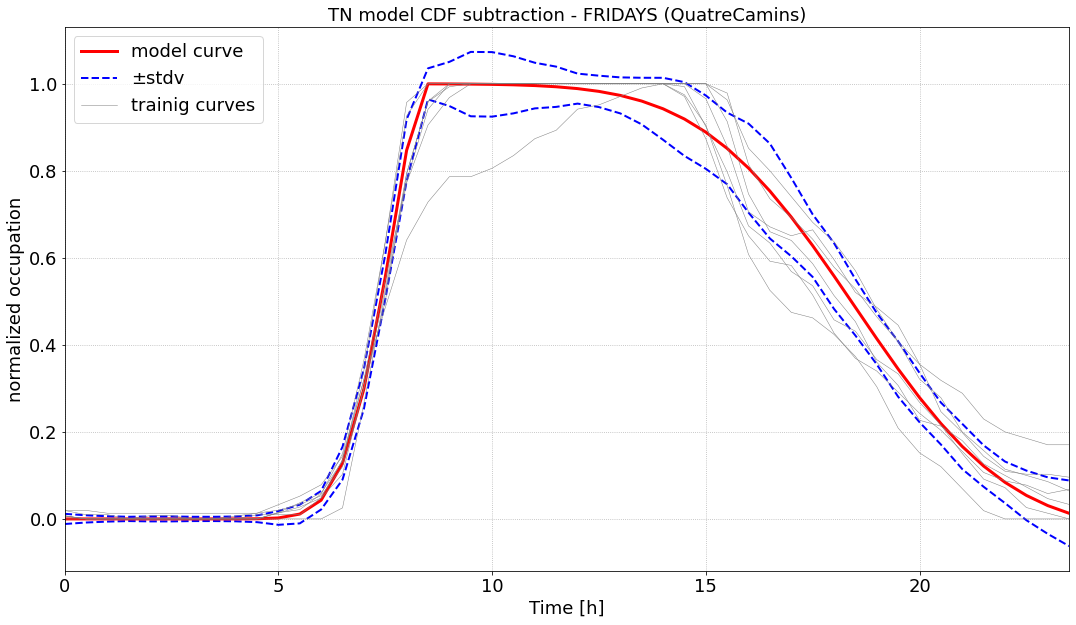

In [26]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

In [27]:
bol_plot_individual_fits = False
if bol_plot_individual_fits:
    tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
    tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

    cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

    for ii in range(0,len(training_fridays_norm)):
        idx_th=ii+4

        cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])


        dayisFull=training_fridays_isfull[ii]
        if dayisFull:
            print(optimal_params_fridaytn.x[idx_th])

            ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridaytn.x[idx_th])
            time_parking_full= 0.5*ix_parking_full
            str_parking_full= f'{int(time_parking_full):02.0f}:{int((time_parking_full-int(time_parking_full))*60):02.0f}h'

            print('Parking full        = '+str_parking_full)
            tn1_fri[cdf1_fri>optimal_params_fridaytn.x[idx_th]] =0
            cdf1_fri[cdf1_fri>optimal_params_fridaytn.x[idx_th]] = optimal_params_fridaytn.x[idx_th]
            cdf1_fri = cdf1_fri/optimal_params_fridaytn.x[idx_th]
        else:
            ix_parking_full=0
        resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
        prototype_math_friday = resta_fri#/sum(resta_fri)
        fig = plt.figure(figsize=(18,10))
        fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
        if dayisFull:
            plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full "+str_parking_full)
        plt.grid(linestyle='dotted')
        plt.xlabel("Time [h]", fontsize=18)
        plt.ylabel("PDF & CDF", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
        #for i in range(0,len(training_fridays_norm)):
        plt.plot(time, training_fridays_norm[ii], linewidth=0.45)
        plt.legend(fontsize=16);

### WEEKENDS

In [28]:
parameters_tn = np.array([.2 ,.05,.7,.1])
if bolTrainagain:
    errors_we = np.ones(np.shape(training_weekends_norm))  
    if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
        optimal_params_weekendtn = minimize(model_tn_max_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors_we),
                                    method='SLSQP',
                                    bounds=((0, None), (0, None),(0, None),(0, None)),
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
    else:
        optimal_params_weekendtn = minimize(model_tn_max_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors_we),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})


In [29]:
if bolTrainagain:
    #save modelparams and error
    with open('data/'+current_parking+'_modelFitTH.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we], f)
        f.close()
    
    # Getting back the objects:
    with open('data/'+current_parking+'_modelFitTH.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()

In [30]:
var_weekendtn = np.mean(errors_we)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors_we,0))
#print('stdv per time-step')
#for i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 1.00000



In [31]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([4.23756984e-01, 1.20748554e-01, 6.40233090e+04, 1.10398231e+02])

In [32]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we#/sum(resta_we)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_we, label="CDF Slot occupied")
#plt.plot(time, cdf2_we, label="CDF Slot free")
#plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
#plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

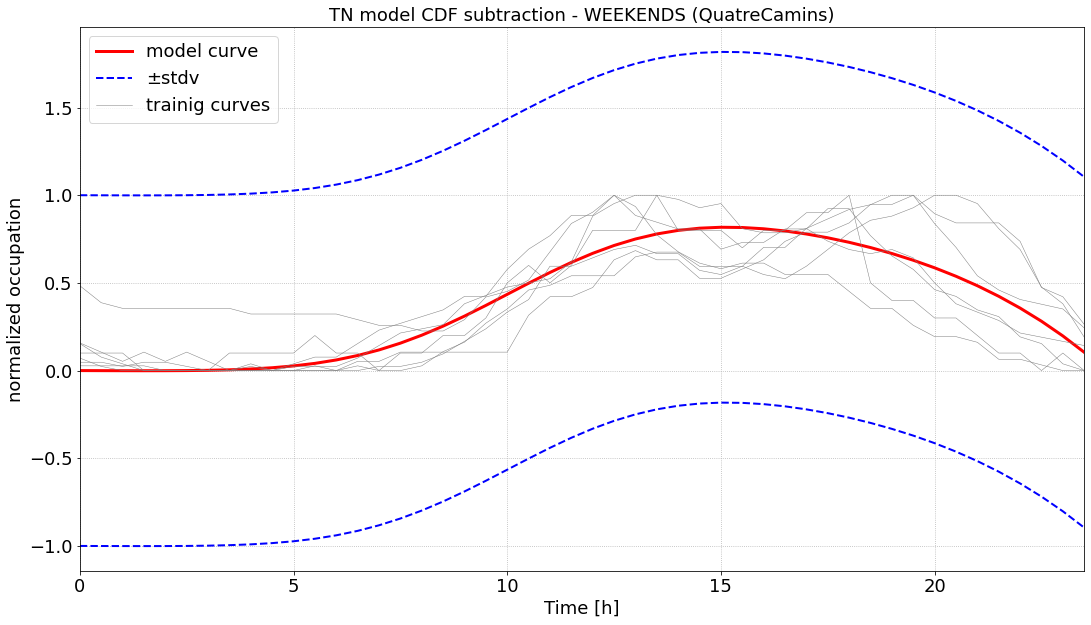

In [33]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [34]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS QuatreCamins -----------
Mean Arrival Time   = 07:31h
stdv Arrival        =  0:52h
Mean Departure Time = 19:24h
stdv Departure      =  1:51h
Parking full        = 08:30h
--------- FRIDAYS QuatreCamins -----------
Mean Arrival Time   = 07:43h
stdv Arrival        =  0:55h
Mean Departure Time = 18:29h
stdv Departure      =  2:49h
Parking full        = 08:30h
--------- WEEKENDS QuatreCamins -----------
Mean Arrival Time   = 10:10h
stdv Arrival        =  2:53h
Mean Departure Time = 1536559:24h
stdv Departure      = 2649:33h


In [35]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

tn_arr_weekday_n = prototype_math_arr_weekday
tn_dep_weekday_n = prototype_math_dep_weekday
tn_arr_friday_n = prototype_math_arr_friday
tn_dep_friday_n = prototype_math_dep_friday

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [36]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_max + weekday_offset
tn_arr_weekday = tn_arr_weekday_n*weekday_max + weekday_offset

tn_weekday_nooff = tn_weekday_n*weekday_max 
tn_arr_weekday_nooff = tn_arr_weekday_n*weekday_max 
tn_dep_weekday = tn_dep_weekday_n*weekday_max #+ weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_max + friday_offset
tn_arr_friday = tn_arr_friday_n*friday_max + friday_offset

tn_friday_nooff = tn_friday_n*friday_max
tn_arr_friday_nooff = tn_arr_friday_n*friday_max
tn_dep_friday = tn_dep_friday_n*friday_max #+ friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_max + weekend_offset 

tn1_weekend_nooff = tn1_weekend_n*weekend_max 

In [37]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

19 cars could not park
26 cars could not park
47 cars could not park
47 cars could not park
33 cars could not park
37 cars could not park
61 cars could not park
35 cars could not park
38 cars could not park
59 cars could not park
26 cars could not park
56 cars could not park
40 cars could not park
______ MEAN ± STDV________
1.8305671885327748  ±  1.187802198478565
1.588231271232931  ±  0.687174286706513
3.0658253121550367  ±  2.356301182671025
4.080146307599764  ±  3.0753729506326137
3.234686496186758  ±  1.881156554979368
1.4446216223202166  ±  0.6038895057300911
1.5398630128235424  ±  0.7823771802230111


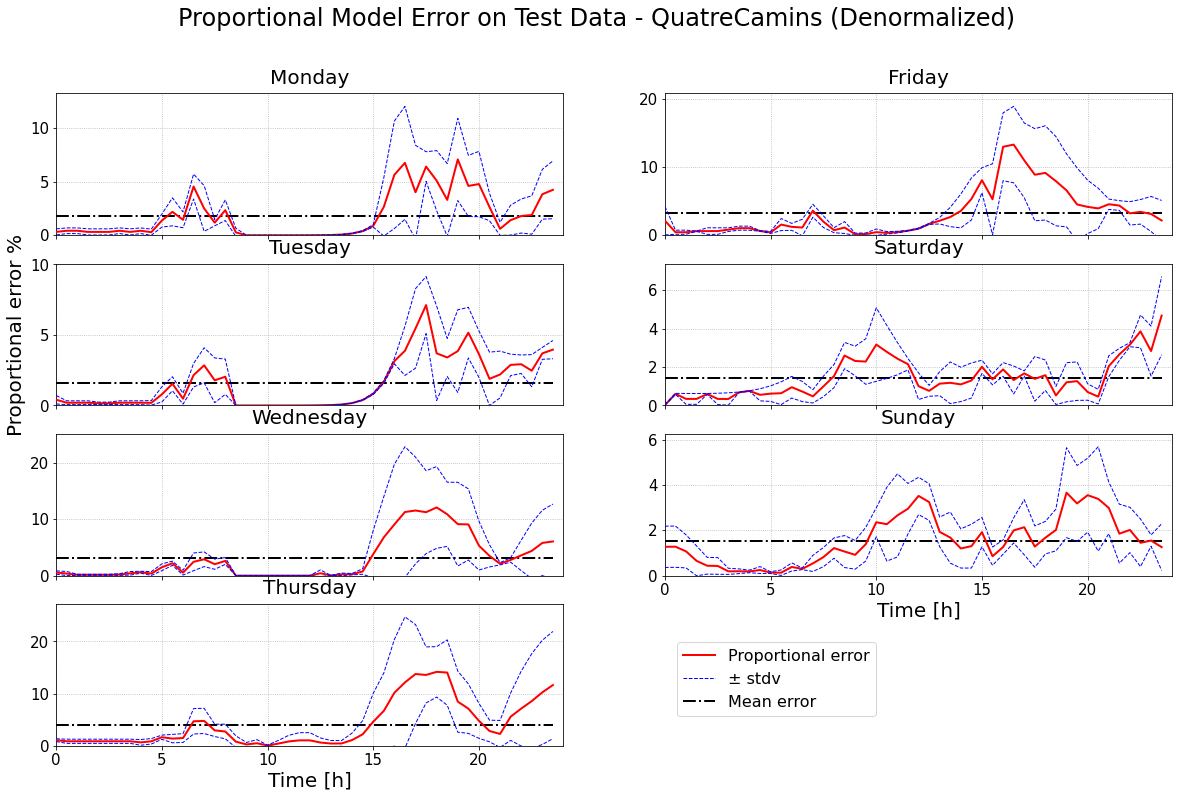

In [38]:

#[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv_fit(testing_mondays, tn_weekday, max_value)
#[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv_fit(testing_tuesdays, tn_weekday, max_value)
#[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv_fit(testing_wednesdays, tn_weekday, max_value)
#[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv_fit(testing_thursdays, tn_weekday, max_value)
#[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv_fit(testing_fridays, tn_friday, max_value)

[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv_fitThdep(testing_mondays, tn_arr_weekday_nooff, tn_dep_weekday, max_value)
[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv_fitThdep(testing_tuesdays, tn_arr_weekday_nooff, tn_dep_weekday, max_value)
[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv_fitThdep(testing_wednesdays, tn_arr_weekday_nooff, tn_dep_weekday, max_value)
[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv_fitThdep(testing_thursdays, tn_arr_weekday_nooff, tn_dep_weekday, max_value)
[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv_fitTh(testing_fridays, tn_arr_friday_nooff, tn_dep_friday, max_value)
[error_saturday_tn,stdv_error_saturday_tn] = compute_testing_prop_errorMstdv_fit(testing_saturdays, tn1_weekend, max_value)
[error_sunday_tn,stdv_error_sunday_tn] = compute_testing_prop_errorMstdv_fit(testing_sundays, tn1_weekend, max_value)



    
fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
mstdv_Monday= np.mean(stdv_error_monday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_tn, stdv_error_monday_tn, mean_Monday, 
                 'Monday', 'Monday',False,False,False,False)


mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
mstdv_Tuesday= np.mean(stdv_error_tuesday_tn[~np.isnan(stdv_error_tuesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_tn, stdv_error_tuesday_tn,  mean_Tuesday, 
                 'Tuesday', 'Tuesday',False,True,False,False)

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
mstdv_Wednesday= np.mean(stdv_error_wednesday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_tn, stdv_error_wednesday_tn, mean_Wednesday, 
                 'Wednesday', 'Wednesday',False,False,False,False)

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
mstdv_Thursday= np.mean(stdv_error_thursday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_tn, stdv_error_thursday_tn, mean_Thursday, 
                 'Thursday', 'Thursday',True,False,True,False)

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
mstdv_Friday= np.mean(stdv_error_friday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_tn, stdv_error_friday_tn, mean_Friday, 
                 'Friday', 'Friday',False,False,False,False)

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
mstdv_Saturday= np.mean(stdv_error_saturday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_tn, stdv_error_saturday_tn, mean_Saturday, 
                 'Saturday', 'Saturday',False,False,False,False)

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
mstdv_Sunday= np.mean(stdv_error_sunday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_tn, stdv_error_sunday_tn, mean_Sunday, 
                 'Sunday', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
fig.savefig('TestError_'+current_parking+'th.pdf',bbox_inches='tight');
#ax[1,1].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print( mean_Monday[0], ' ± ', mstdv_Monday)
print(mean_Tuesday[0], ' ± ', mstdv_Tuesday)
print(mean_Wednesday[0], ' ± ', mstdv_Wednesday)
print(mean_Thursday[0], ' ± ', mstdv_Thursday)
print(mean_Friday[0], ' ± ', mstdv_Friday)
print(mean_Saturday[0], ' ± ', mstdv_Saturday)
print(mean_Sunday[0], ' ± ', mstdv_Sunday)
#print('______STDV________')

#print(np.std(error_monday_tn))
#print(np.std(error_tuesday_tn))
#print(np.std(error_wednesday_tn))
#print(np.std(error_thursday_tn))
#print(np.std(error_friday_tn))
#print(np.std(error_saturday_tn))
#print(np.std(error_sunday_tn))

#2.7099637370236747  ±  1.4736557849835552
#1.925942761285978  ±  0.9518195298543765
#4.466166164768858  ±  3.598647373249273
#4.958390536998728  ±  3.2336490787488423
#3.5121002753705888  ±  1.9714569641577306
#1.4446216223202166  ±  0.6038895057300911
#1.5398630128235424  ±  0.7823771802230111


#2.228801820252222  ±  1.2395925005732904
#1.609811647344771  ±  0.7446884490736162
#3.625330724308389  ±  3.1692274849228514
#4.465706101107658  ±  3.0252730281329576
#3.234686496186758  ±  1.881156554979368
#1.4446216223202166  ±  0.6038895057300911
#1.5398630128235424  ±  0.7823771802230111

In [39]:
m_row=[current_parking,'meanE',mean_Monday[0], mean_Tuesday[0], mean_Wednesday[0], mean_Thursday[0],
       mean_Friday[0],mean_Saturday[0], mean_Sunday[0]]
s_row=[current_parking,'mStdvE',mstdv_Monday, mstdv_Tuesday, mstdv_Wednesday,  mstdv_Thursday, 
       mstdv_Friday, mstdv_Saturday, mstdv_Sunday]

In [40]:
f = open('data/'+current_parking+'_testErrorTH.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row)
writer.writerow(s_row)

# close the file
f.close()

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [41]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

In [42]:
def plot_prototype_fit():
    for i in range(0,len(tn_proto)):
        if tn_proto[i] < 0:
            tn_proto[i] = 0
    cont=0
    for i in range(0,len(t_days)):
        t_date=t_dates[cont]
        print(t_date)
        #tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
        tn_arr_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_arr_proto)
        stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)

        #scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
        scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
        scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]
        
    
        if max(scaled_tn_arr_proto)>max_value:
            cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
            print(round(cars_could_not_park), "cars could not park")
            scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
            scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
        
        scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

        scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
        fig, ax = plt.subplots(1, 2)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        axx=0;
        real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                              scaled_tn_proto2, scaled_stat_proto, limit_hour, t_date, current_parking)
        axx=1;
        errors_plottingM(fig, ax, axx, scaled_tn_proto2, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
        cont=cont+1

In [43]:
def plot_prototype_fitTH():
    for i in range(0,len(tn_proto)):
        if tn_proto[i] < 0:
            tn_proto[i] = 0
    cont=0
    for i in range(0,len(t_days)):
        t_date=t_dates[cont]
        print(t_date)
        #tn_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_proto, max_value)
        tn_arr_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_arr_proto)
        stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)

        #scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
        scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
        scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]
        
    
        if max(scaled_tn_arr_proto)>max_value:
            cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
            print(round(cars_could_not_park), "cars could not park")
            scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
            scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
        
        scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

        scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
        fig, ax = plt.subplots(1, 2)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        axx=0;
        real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                              scaled_tn_proto2, scaled_stat_proto, limit_hour, t_date, current_parking)
        axx=1;
        errors_plottingM(fig, ax, axx, scaled_tn_proto2, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
        cont=cont+1

#### MONDAY

In [44]:
statistic_proto = hist_weekday_proto
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 7.5
day = 'Monday'

2020-02-24
Real Monday scaled prototype error:  6.47 %
Real Monday scaled prototype error (median):  3.31 %
Real Monday scaled prototype STDV: 5.379817966359201
Real Monday scaled TN error:  31.42 %
Real Monday scaled TN error (median):  33.63 %
Real Monday scaled TN STDV:  17.675634748471225
_____________________________________________________________
2020-03-02
Real Monday scaled prototype error:  12.45 %
Real Monday scaled prototype error (median):  15.72 %
Real Monday scaled prototype STDV: 6.554777136872331
Real Monday scaled TN error:  10.7 %
Real Monday scaled TN error (median):  12.55 %
Real Monday scaled TN STDV:  5.38330197693971
_____________________________________________________________
2020-03-09
3 cars could not park
Real Monday scaled prototype error:  4.48 %
Real Monday scaled prototype error (median):  4.39 %
Real Monday scaled prototype STDV: 1.755033982927419
Real Monday scaled TN error:  3.02 %
Real Monday scaled TN error (median):  1.65 %
Real Monday scaled TN S

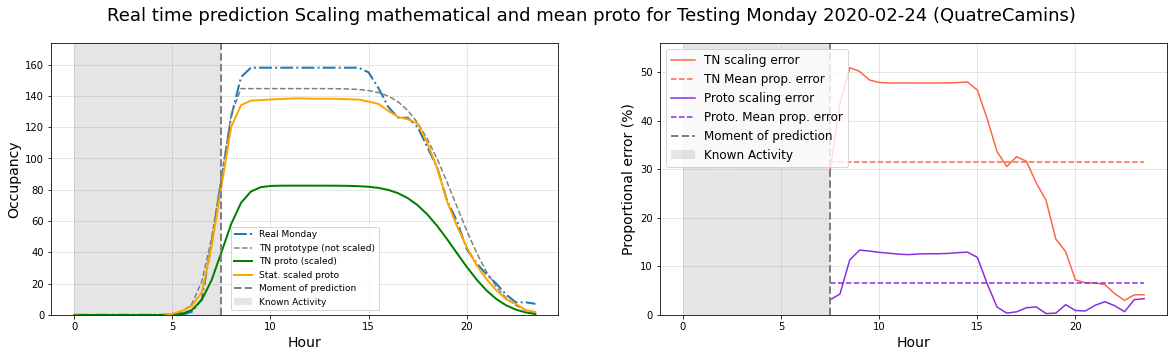

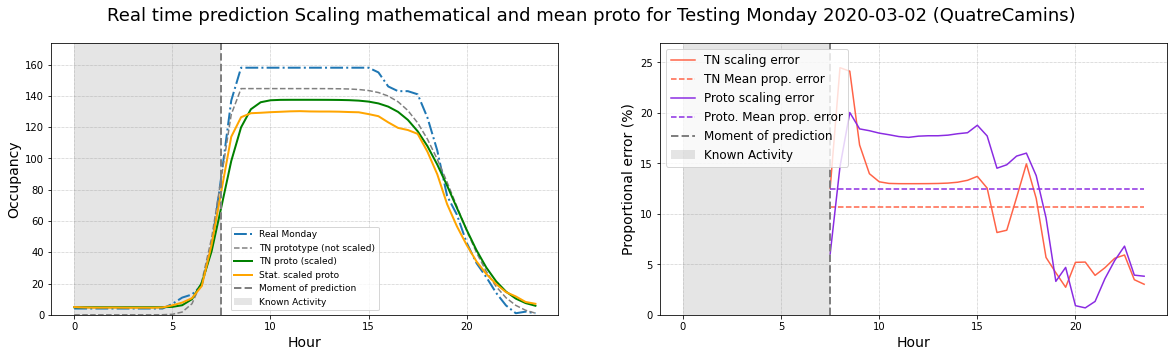

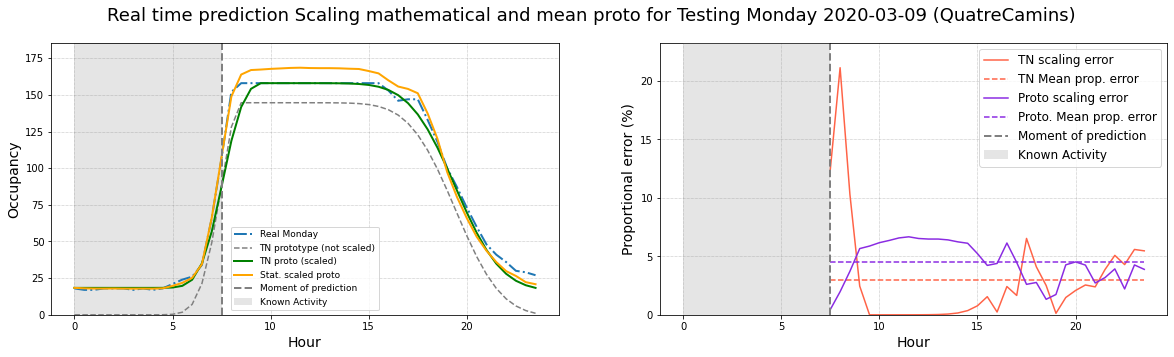

In [45]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

In [46]:
starting_hour=7

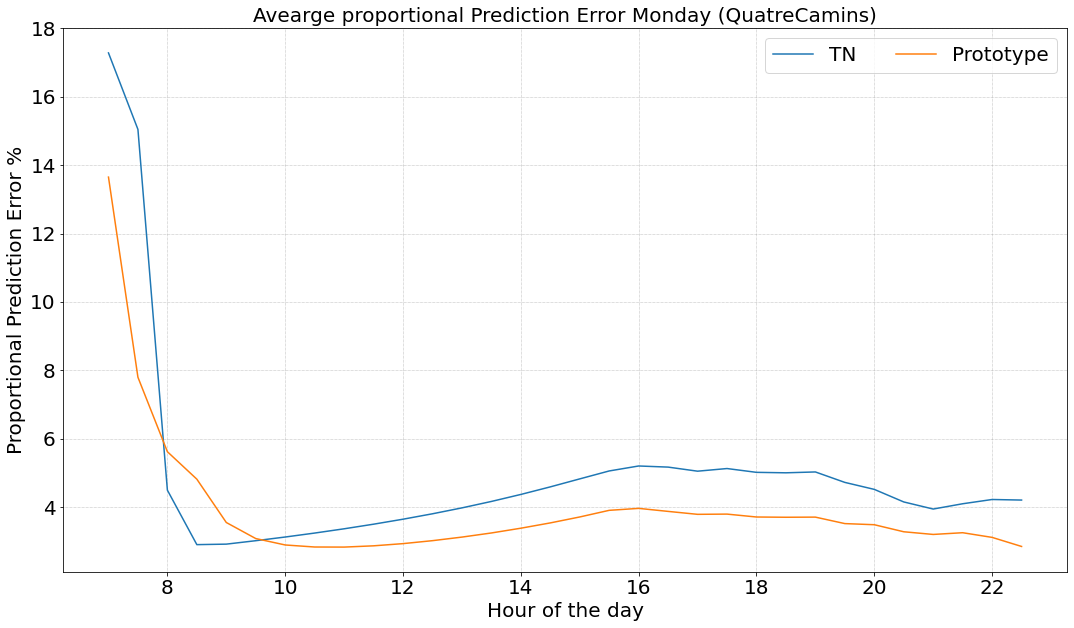

In [47]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [48]:
proto_running_error_wd=proto_running_error_vec
tn_running_error_wd=tn_running_error_vec

#### TUESDAY

In [49]:
statistic_proto = hist_weekday_proto
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 7.5
day = 'Tuesday'

In [50]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday

2020-02-25
47 cars could not park


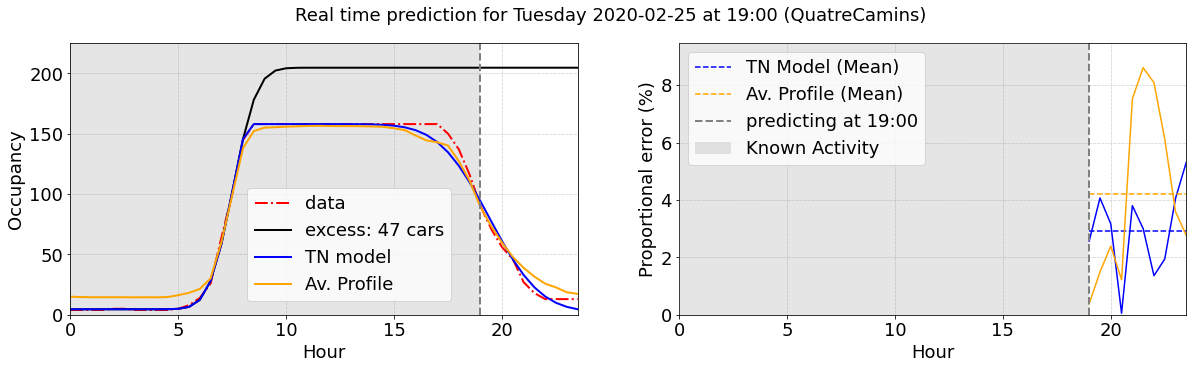

In [51]:
limit_hour = 19
fsize=18

if isinstance(limit_hour, int):
    hourstring = str(limit_hour) + ':00'
else:
    hourstring = str(int(limit_hour))+':'+str(int((limit_hour-int(limit_hour))*60))

for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
cont=0
i=0

t_date=t_dates[cont]
print(t_date)
#tn_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_proto, max_value)
tn_arr_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_arr_proto)
stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)

#scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]

scaled_tn_arr_proto_uncut=scaled_tn_arr_proto.copy()

if max(scaled_tn_arr_proto)>max_value:
    cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
    print(round(cars_could_not_park), "cars could not park")
    scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
    scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
else: 
    cars_could_not_park=0
    
scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

#scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
scaled_stat_proto = statistic_proto.values 
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(5)
axx=0;
time = np.linspace(0,23.5,48)
fig.suptitle('Real time prediction for '
             + day + ' ' +t_date + ' at '+ hourstring +' ('+ current_parking+')', fontsize=fsize)
ax[axx].plot(time, t_days[i].values, linestyle='dashdot', color='red', linewidth=2, label='data')
#ax[axx].plot(time, tn_proto,'--',color='grey', label='TN prototype (not scaled)')
if cars_could_not_park>0:
    ax[axx].plot(time, scaled_tn_arr_proto_uncut, color='black', linewidth=2, 
             label='excess: '+str(round(cars_could_not_park)) + ' cars')
ax[axx].plot(time, scaled_tn_proto2, color='blue', linewidth=2, label='TN model')
ax[axx].plot(time, scaled_stat_proto, color='orange', linewidth=2, label='Av. Profile')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2)
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].set_ylim([0,1.1*max([max(t_days[i].values),max(tn_proto),max(scaled_tn_proto2),
                             max(scaled_stat_proto),max(scaled_tn_arr_proto_uncut)])])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_xlim([0,23.5])
ax[axx].set_ylabel('Occupancy', fontsize=fsize)
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)
ax[axx].legend(fontsize=fsize,loc="best", bbox_to_anchor=(0.55,0.5))

#
axx=1;

limit_hourIdx = int(limit_hour*2)
tn_scaled_error = (np.absolute((np.array(scaled_tn_proto2) - np.array(t_days[i].values)))/max_value)*100
mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/max_value)*100

#tn_scaled_error = (np.absolute((np.array(scaled_tn_proto2) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100
#mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100

tn_s_error_mean = [np.mean(tn_scaled_error[limit_hourIdx:])]*len(tn_scaled_error)
mean_s_error_mean = [np.mean(mean_scaled_error[limit_hourIdx:])]*len(mean_scaled_error)

#Second plot
#     time = time[limit_hour:]
ax[axx].plot(time[limit_hourIdx:], tn_scaled_error[limit_hourIdx:], color='blue') #, label='TN Model')
ax[axx].plot(time[limit_hourIdx:],tn_s_error_mean[limit_hourIdx:], '--',color='blue', label='TN Model (Mean)')
ax[axx].plot(time[limit_hourIdx:],mean_scaled_error[limit_hourIdx:], color='orange')#, label='Average Profile')
ax[axx].plot(time[limit_hourIdx:],mean_s_error_mean[limit_hourIdx:], '--',color='orange', label='Av. Profile (Mean)')
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2, label='predicting at '+ hourstring)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2, zorder=4, label='Known Activity')
ax[axx].set_xlim([0,23.5])
ax[axx].legend(fontsize=fsize)
ax[axx].set_ylim([0,1.1*max(max(tn_scaled_error[limit_hourIdx:]),max(mean_scaled_error[limit_hourIdx:]))])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_ylabel('Proportional error (%)', fontsize=fsize);
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)

fig.savefig('ExamplePrediction_'+current_parking+'TH_'+hourstring.replace(':','h') +'.pdf',bbox_inches='tight');

2020-02-25
47 cars could not park
Real Tuesday scaled prototype error:  2.05 %
Real Tuesday scaled prototype error (median):  2.18 %
Real Tuesday scaled prototype STDV: 1.1801740042139273
Real Tuesday scaled TN error:  2.94 %
Real Tuesday scaled TN error (median):  3.09 %
Real Tuesday scaled TN STDV:  1.447196487591218
_____________________________________________________________
2020-03-03
33 cars could not park
Real Tuesday scaled prototype error:  1.5 %
Real Tuesday scaled prototype error (median):  1.37 %
Real Tuesday scaled prototype STDV: 0.7754846366043413
Real Tuesday scaled TN error:  4.2 %
Real Tuesday scaled TN error (median):  3.14 %
Real Tuesday scaled TN STDV:  2.4916121835090004
_____________________________________________________________
2020-03-10
37 cars could not park
Real Tuesday scaled prototype error:  2.63 %
Real Tuesday scaled prototype error (median):  1.12 %
Real Tuesday scaled prototype STDV: 3.2310655511504653
Real Tuesday scaled TN error:  3.24 %
Real Tues

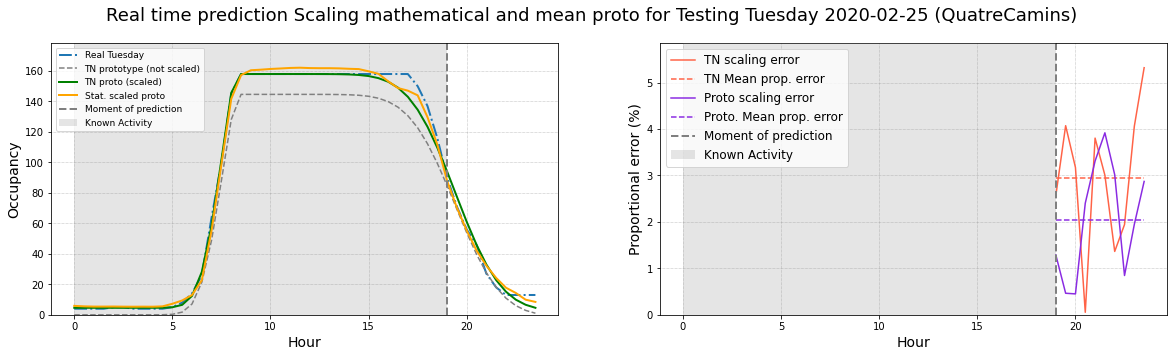

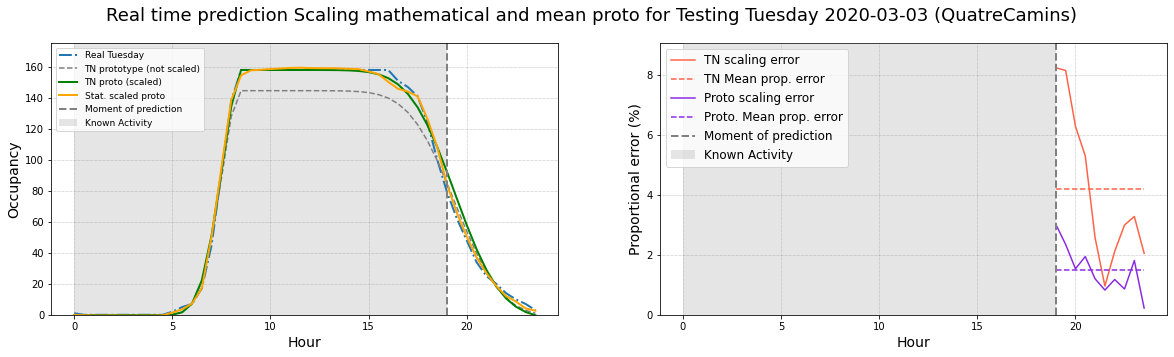

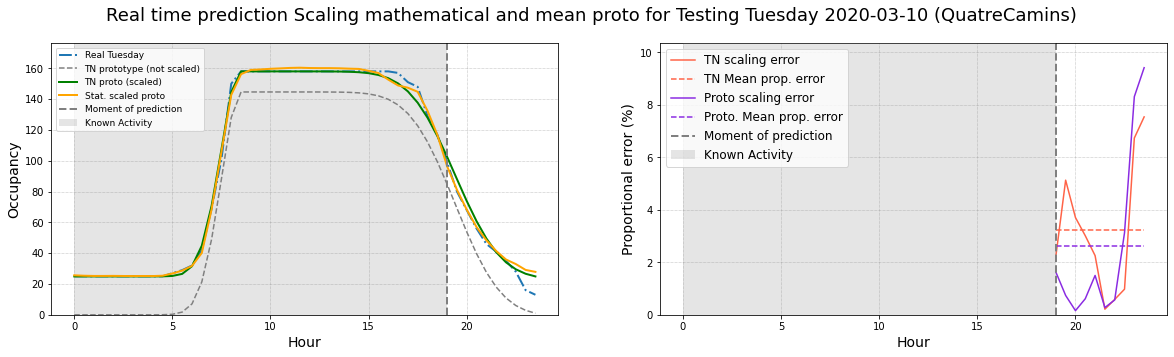

In [52]:

plot_prototype_fitTH()

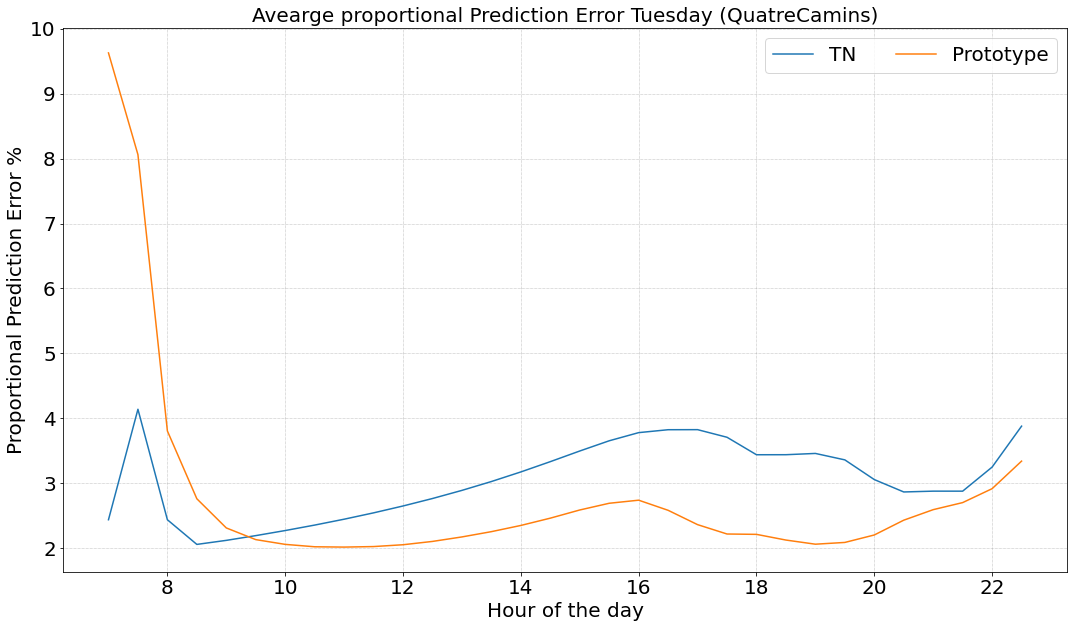

In [53]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [54]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

### WEDNESDAY

In [55]:
statistic_proto = hist_weekday_proto
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 7
day = 'Wednesday'

2020-02-26
128 cars could not park
Real Wednesday scaled prototype error:  29.73 %
Real Wednesday scaled prototype error (median):  34.46 %
Real Wednesday scaled prototype STDV: 17.10152516209399
Real Wednesday scaled TN error:  2.88 %
Real Wednesday scaled TN error (median):  0.85 %
Real Wednesday scaled TN STDV:  4.710648017916911
_____________________________________________________________
2020-03-04
37 cars could not park
Real Wednesday scaled prototype error:  1.82 %
Real Wednesday scaled prototype error (median):  1.49 %
Real Wednesday scaled prototype STDV: 1.1052672578403064
Real Wednesday scaled TN error:  1.65 %
Real Wednesday scaled TN error (median):  0.98 %
Real Wednesday scaled TN STDV:  2.328191108588587
_____________________________________________________________
2020-03-11
63 cars could not park
Real Wednesday scaled prototype error:  10.4 %
Real Wednesday scaled prototype error (median):  8.26 %
Real Wednesday scaled prototype STDV: 9.745237636733497
Real Wednesday 

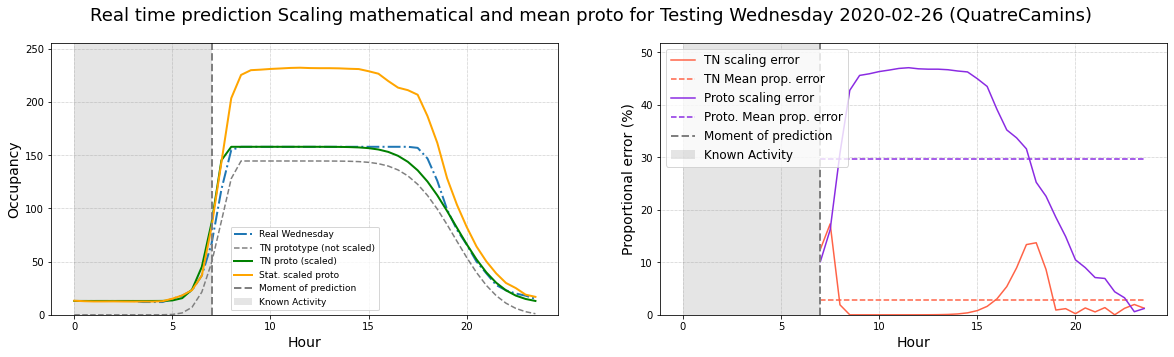

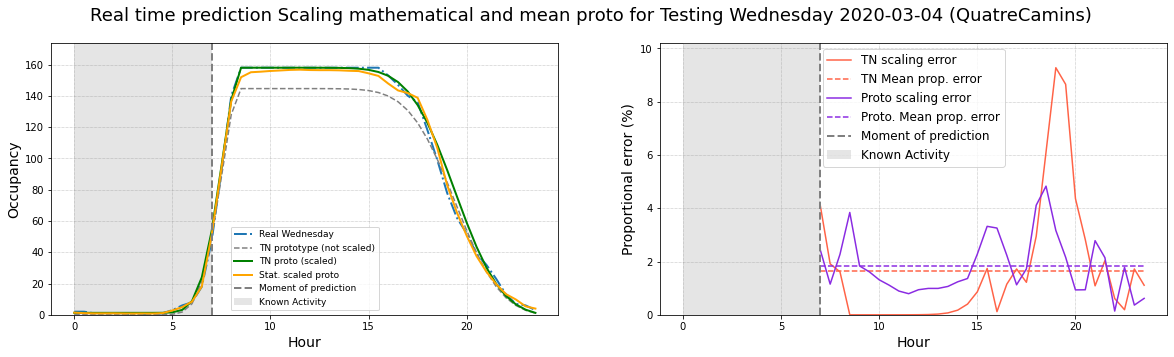

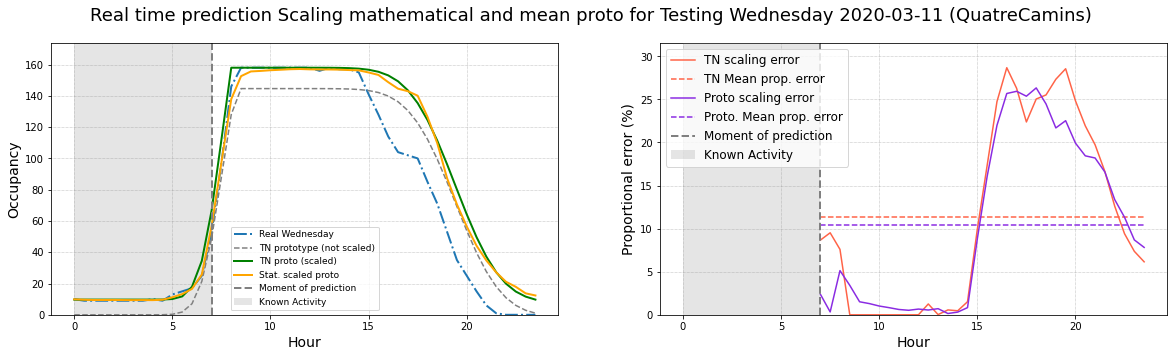

In [56]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

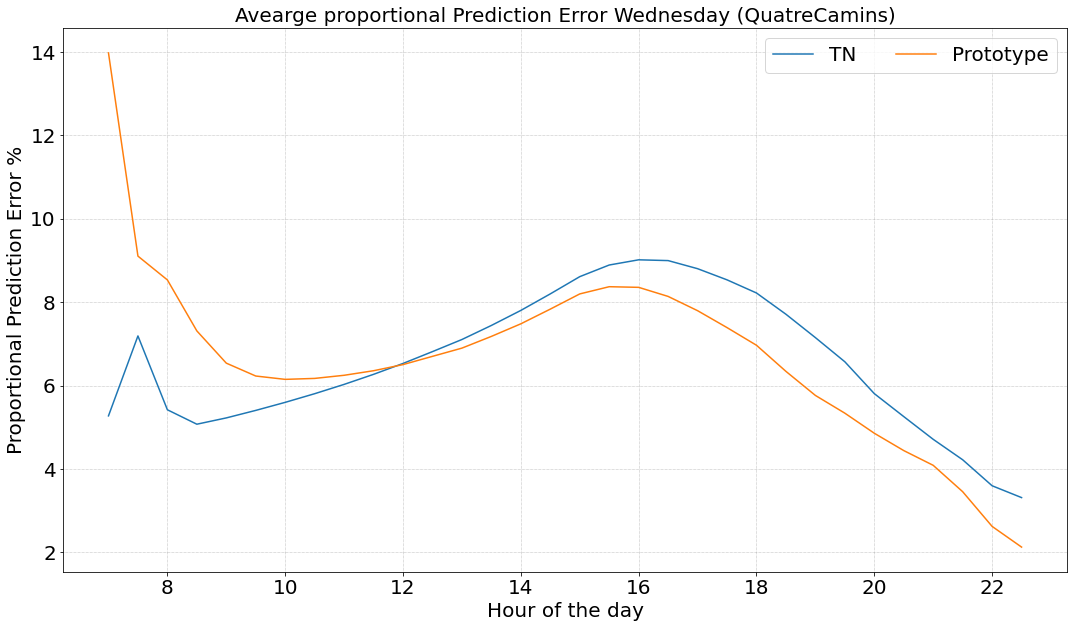

In [57]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [58]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

### THURSDAY

In [59]:
statistic_proto = hist_weekday_proto
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 7
day = 'Thursday'

2020-02-27
169 cars could not park
Real Thursday scaled prototype error:  22.42 %
Real Thursday scaled prototype error (median):  27.4 %
Real Thursday scaled prototype STDV: 16.162714280312237
Real Thursday scaled TN error:  5.34 %
Real Thursday scaled TN error (median):  1.74 %
Real Thursday scaled TN STDV:  7.105394189641303
_____________________________________________________________
2020-03-05
Real Thursday scaled prototype error:  17.06 %
Real Thursday scaled prototype error (median):  21.19 %
Real Thursday scaled prototype STDV: 7.58163904710352
Real Thursday scaled TN error:  5.36 %
Real Thursday scaled TN error (median):  3.85 %
Real Thursday scaled TN STDV:  3.8783149844719027
_____________________________________________________________
2020-03-12
Real Thursday scaled prototype error:  44.48 %
Real Thursday scaled prototype error (median):  46.92 %
Real Thursday scaled prototype STDV: 31.354289656074737
Real Thursday scaled TN error:  54.43 %
Real Thursday scaled TN error (m

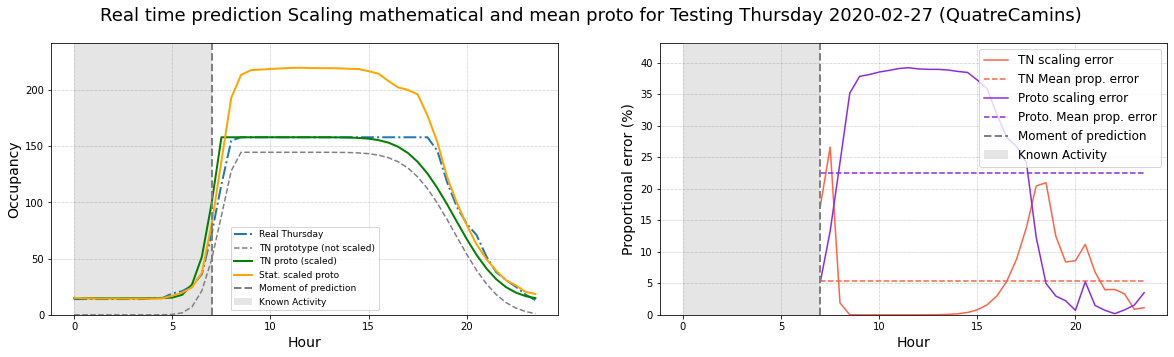

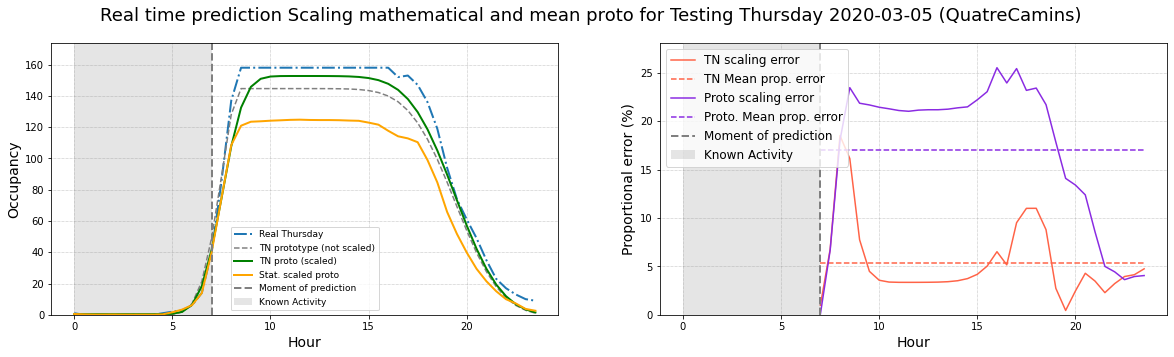

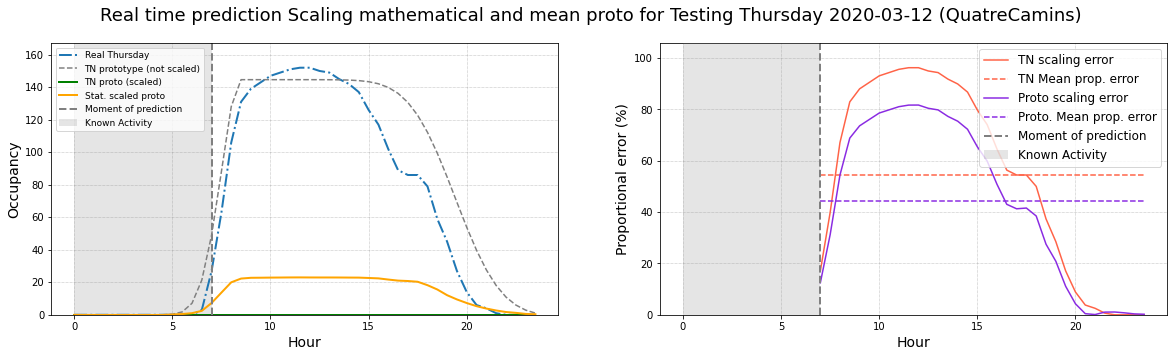

In [60]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

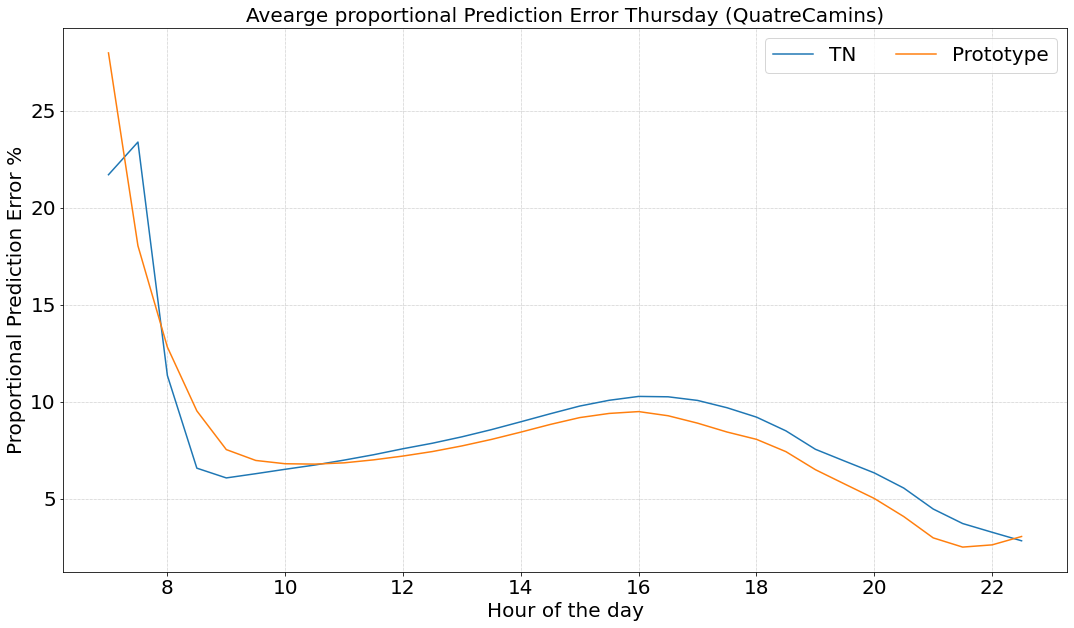

In [61]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [62]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

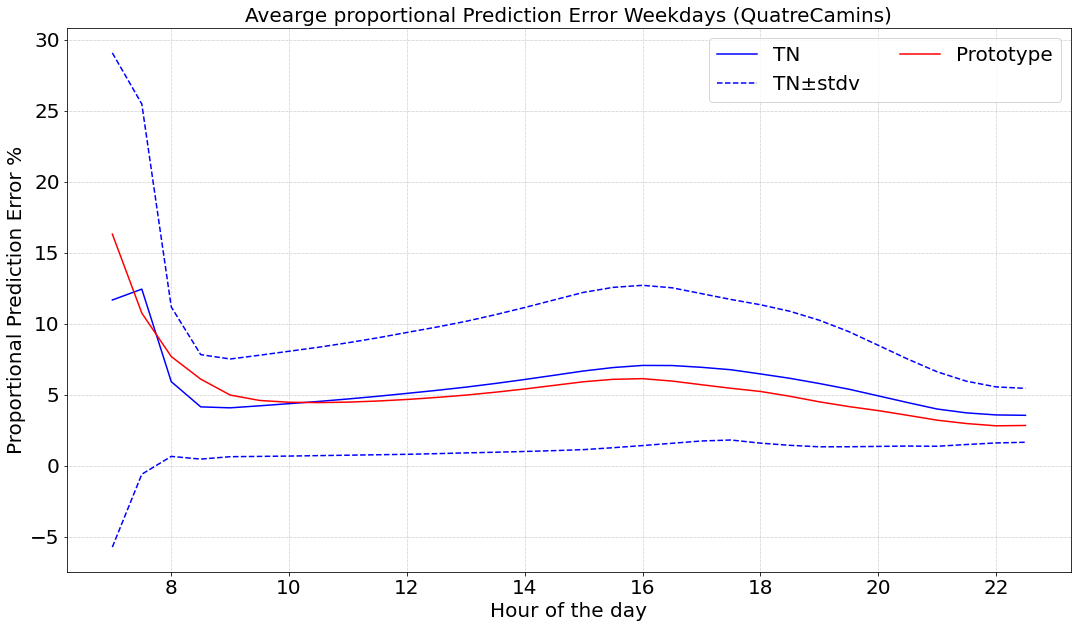

In [63]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_wd,proto_running_error_wd,starting_hour,"Weekdays",current_parking)

### FRIDAY

In [64]:
statistic_proto = hist_friday_proto
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'

2020-02-28
56 cars could not park
Real Friday scaled prototype error:  2.86 %
Real Friday scaled prototype error (median):  2.09 %
Real Friday scaled prototype STDV: 2.067701520718526
Real Friday scaled TN error:  2.41 %
Real Friday scaled TN error (median):  1.65 %
Real Friday scaled TN STDV:  2.2459855613998716
_____________________________________________________________
2020-03-06
40 cars could not park
Real Friday scaled prototype error:  3.84 %
Real Friday scaled prototype error (median):  3.77 %
Real Friday scaled prototype STDV: 1.6705162761600076
Real Friday scaled TN error:  6.57 %
Real Friday scaled TN error (median):  5.92 %
Real Friday scaled TN STDV:  3.2764701781504137
_____________________________________________________________
2020-03-13
Real Friday scaled prototype error:  8.53 %
Real Friday scaled prototype error (median):  9.53 %
Real Friday scaled prototype STDV: 5.395182082608089
Real Friday scaled TN error:  10.36 %
Real Friday scaled TN error (median):  10.86 %

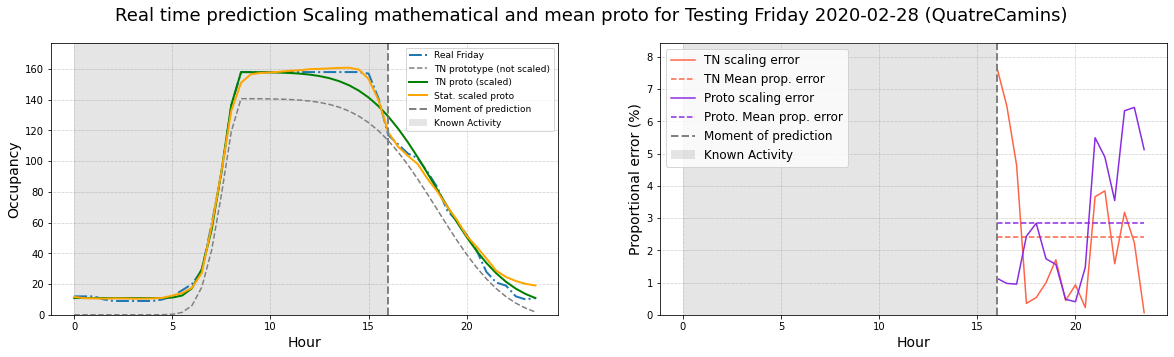

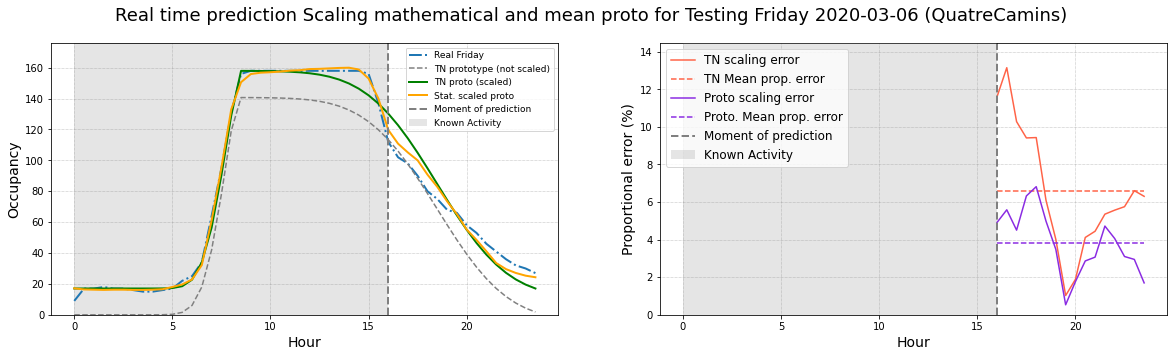

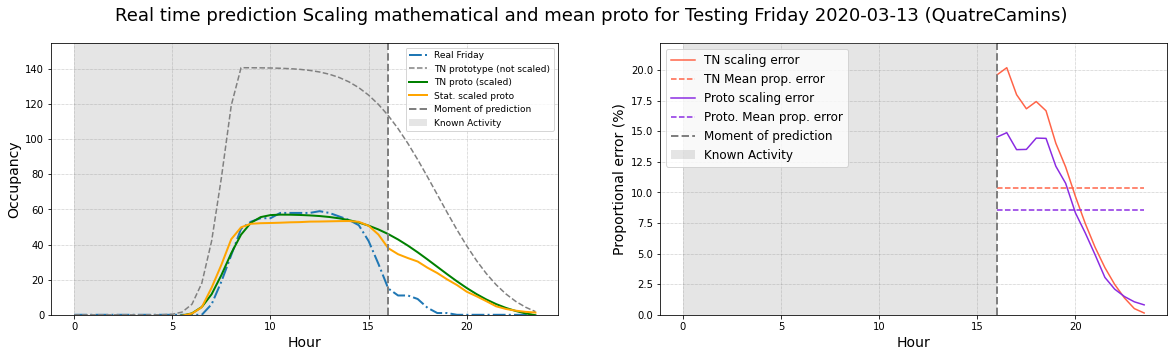

In [65]:
tn_proto = tn_friday_nooff

tn_arr_proto = tn_arr_friday_nooff
tn_dep_proto = tn_dep_friday
plot_prototype_fitTH()

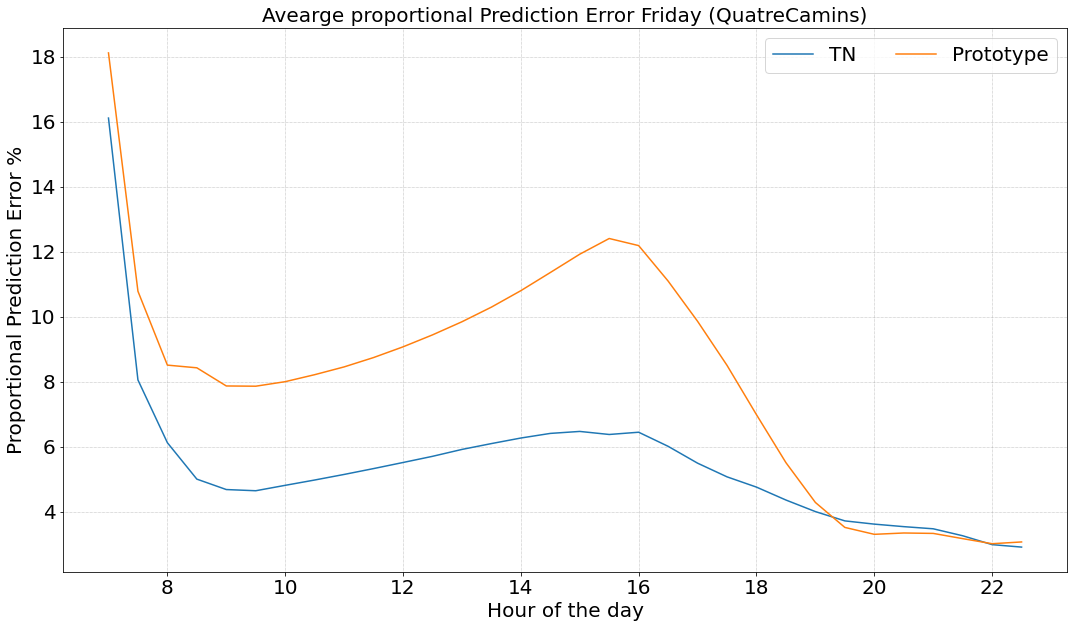

In [66]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [67]:
proto_running_error_fr=proto_running_error_vec
tn_running_error_fr=tn_running_error_vec

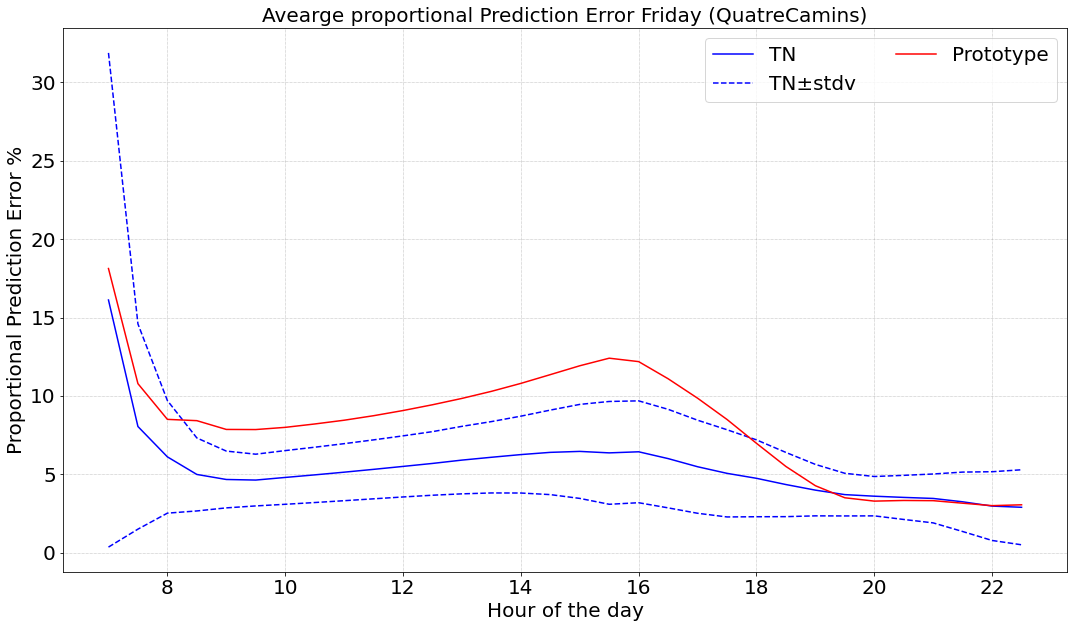

In [68]:

figH=plotRunningPredcitionErrorSTDV(tn_running_error_fr,proto_running_error_fr,starting_hour,day,current_parking)

### WEEKEND

### SATURDAY

In [69]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-22
Real Saturday scaled prototype error:  1.7 %
Real Saturday scaled prototype error (median):  1.8 %
Real Saturday scaled prototype STDV: 0.7977105268640413
Real Saturday scaled TN error:  2.07 %
Real Saturday scaled TN error (median):  2.32 %
Real Saturday scaled TN STDV:  0.8398574724745881
_____________________________________________________________
2020-02-29
Real Saturday scaled prototype error:  2.85 %
Real Saturday scaled prototype error (median):  2.57 %
Real Saturday scaled prototype STDV: 1.2852286551551837
Real Saturday scaled TN error:  2.81 %
Real Saturday scaled TN error (median):  3.06 %
Real Saturday scaled TN STDV:  1.6436779514890225
_____________________________________________________________


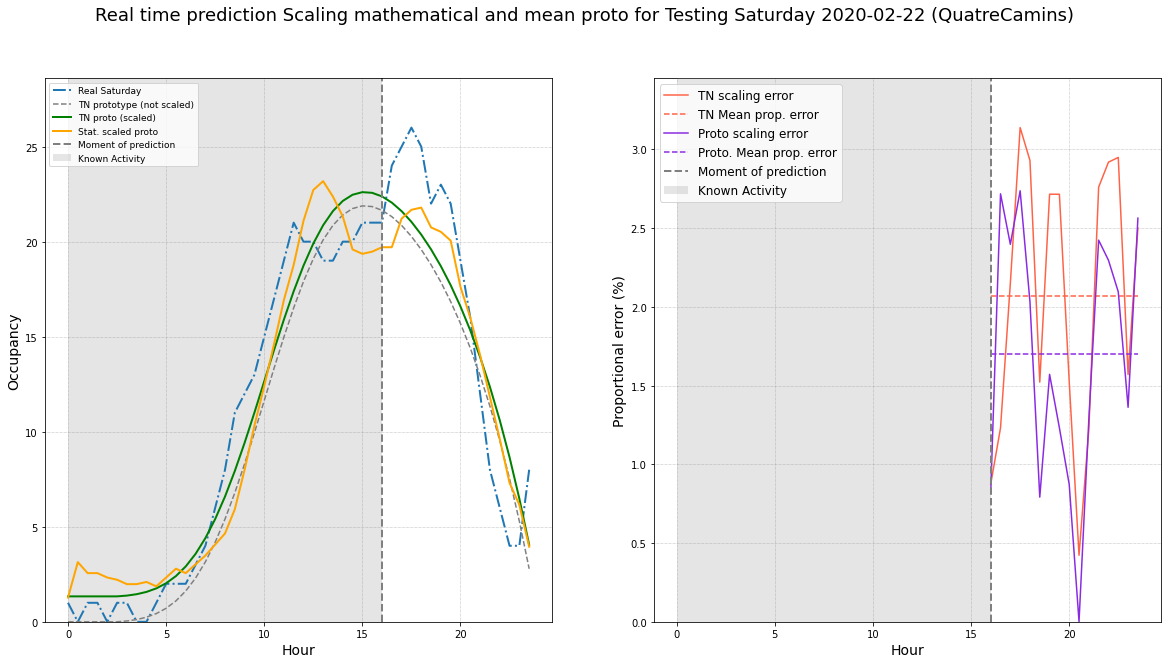

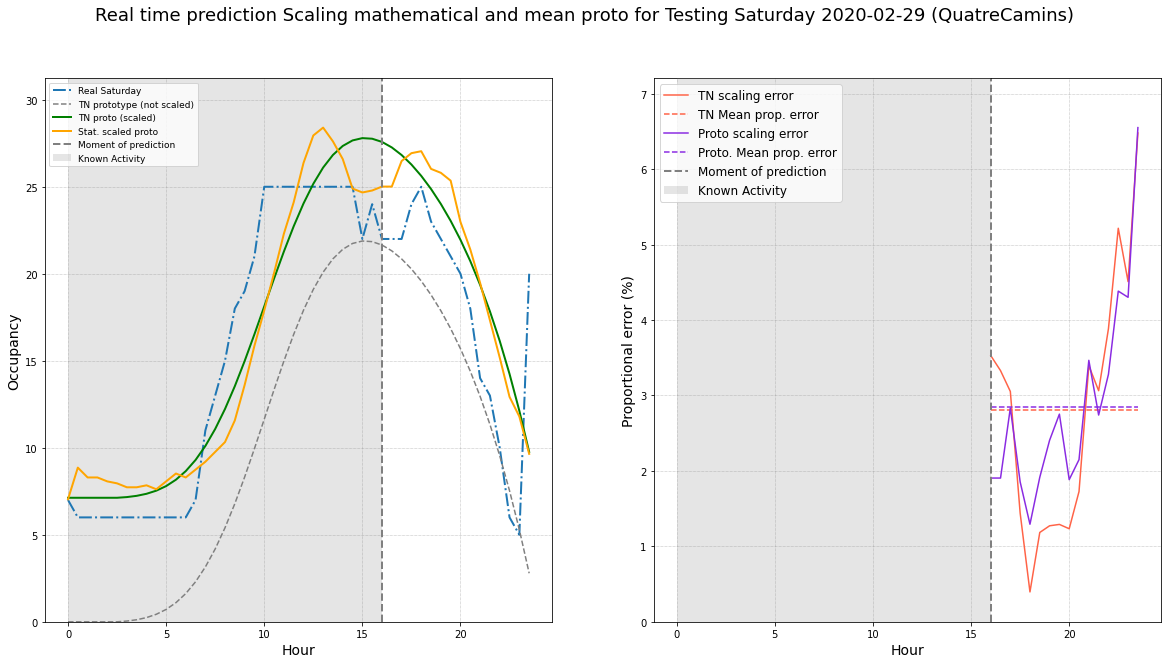

In [70]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

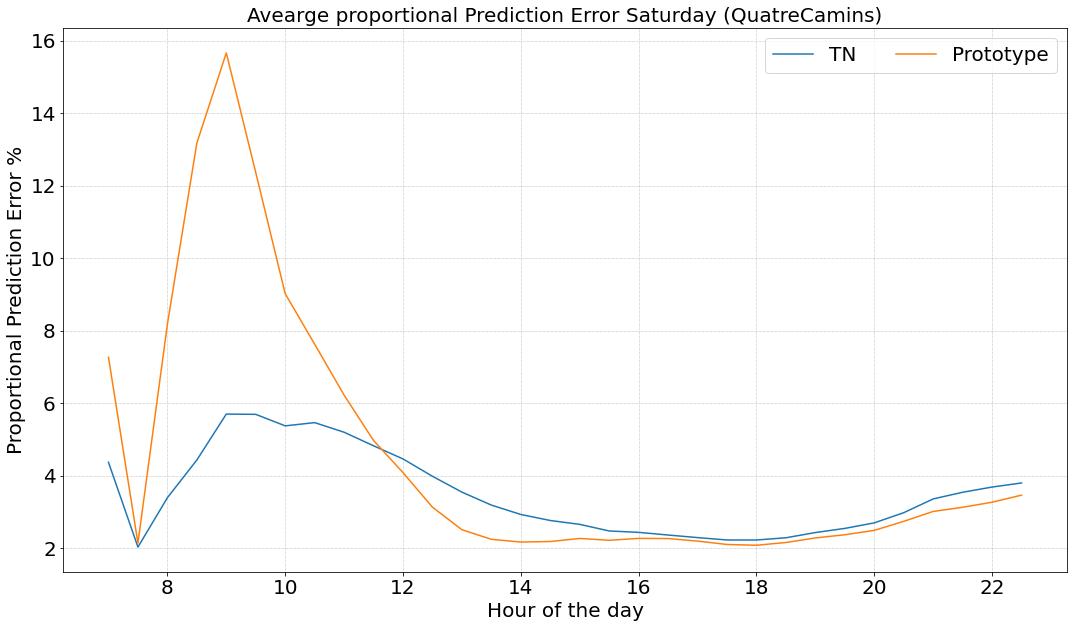

In [71]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [72]:
proto_running_error_we=proto_running_error_vec
tn_running_error_we=tn_running_error_vec

2020-02-22
Real Saturday scaled prototype error:  2.99 %
Real Saturday scaled prototype error (median):  2.11 %
Real Saturday scaled prototype STDV: 2.403517530446649
Real Saturday scaled TN error:  2.85 %
Real Saturday scaled TN error (median):  2.65 %
Real Saturday scaled TN STDV:  1.724109526483923
_____________________________________________________________
2020-02-29
Real Saturday scaled prototype error:  2.1 %
Real Saturday scaled prototype error (median):  1.01 %
Real Saturday scaled prototype STDV: 2.1865202491097264
Real Saturday scaled TN error:  2.04 %
Real Saturday scaled TN error (median):  1.7 %
Real Saturday scaled TN STDV:  1.763387857140034
_____________________________________________________________


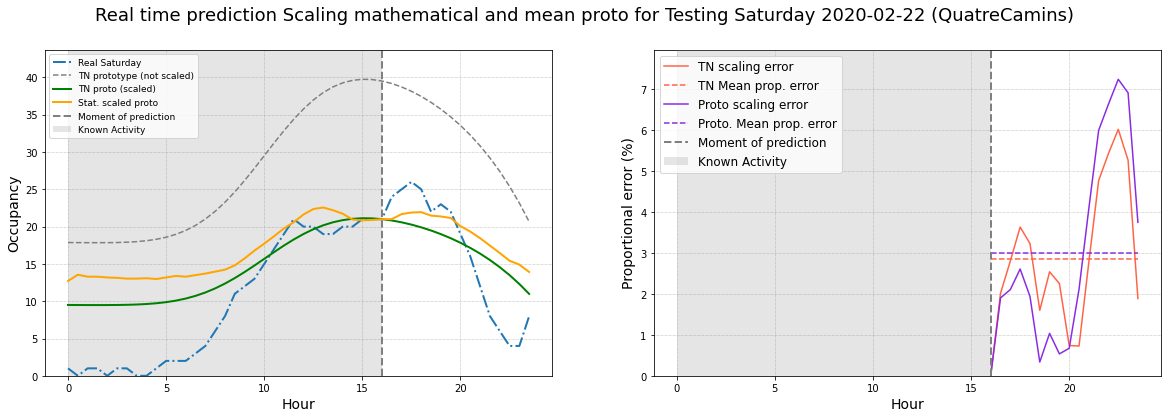

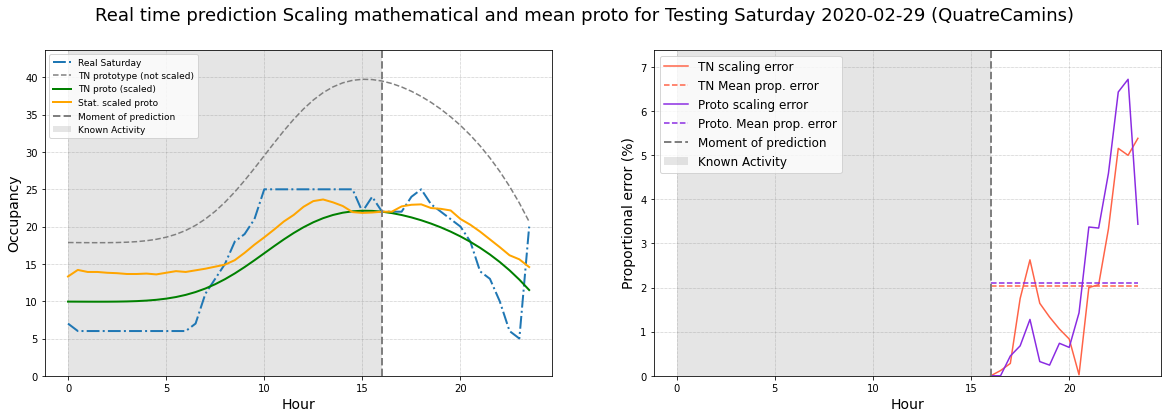

In [73]:
tn_proto = tn1_weekend   
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

In [74]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-23
Real Sunday scaled prototype error:  4.44 %
Real Sunday scaled prototype error (median):  4.48 %
Real Sunday scaled prototype STDV: 1.6128649394412178
Real Sunday scaled TN error:  4.95 %
Real Sunday scaled TN error (median):  5.17 %
Real Sunday scaled TN STDV:  1.5325020553023725
_____________________________________________________________
2020-03-01
Real Sunday scaled prototype error:  3.29 %
Real Sunday scaled prototype error (median):  2.24 %
Real Sunday scaled prototype STDV: 2.9089429058030185
Real Sunday scaled TN error:  3.64 %
Real Sunday scaled TN error (median):  2.79 %
Real Sunday scaled TN STDV:  2.5095734631549025
_____________________________________________________________
2020-03-08
Real Sunday scaled prototype error:  3.21 %
Real Sunday scaled prototype error (median):  3.03 %
Real Sunday scaled prototype STDV: 1.8210347729853675
Real Sunday scaled TN error:  2.46 %
Real Sunday scaled TN error (median):  2.4 %
Real Sunday scaled TN STDV:  1.808703751299068

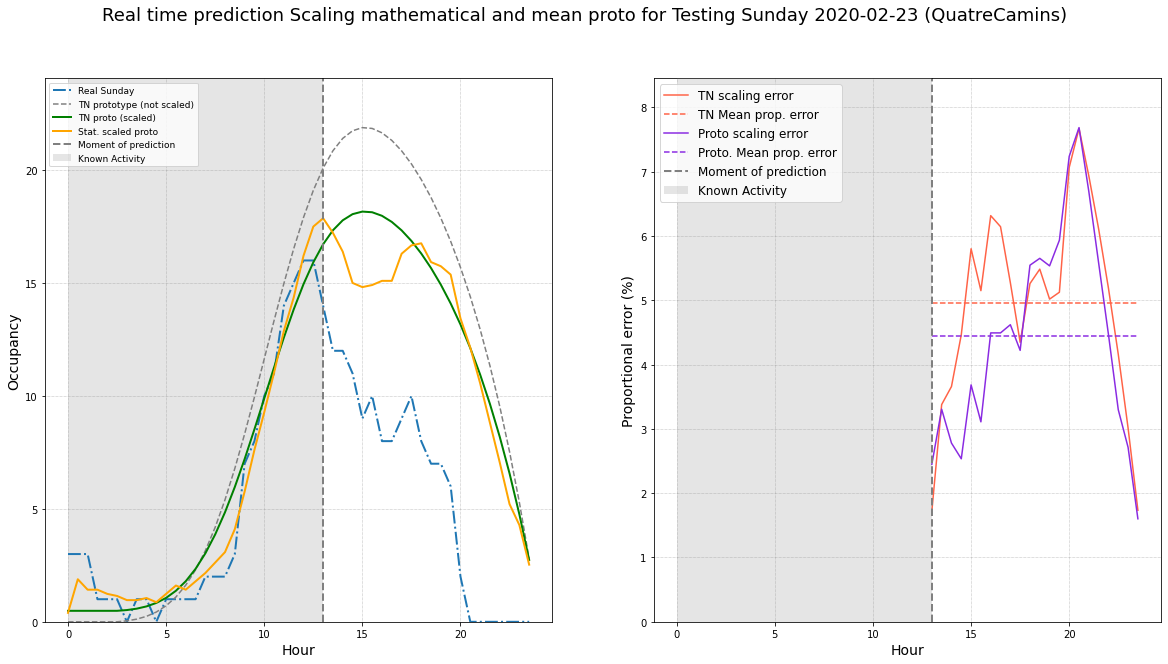

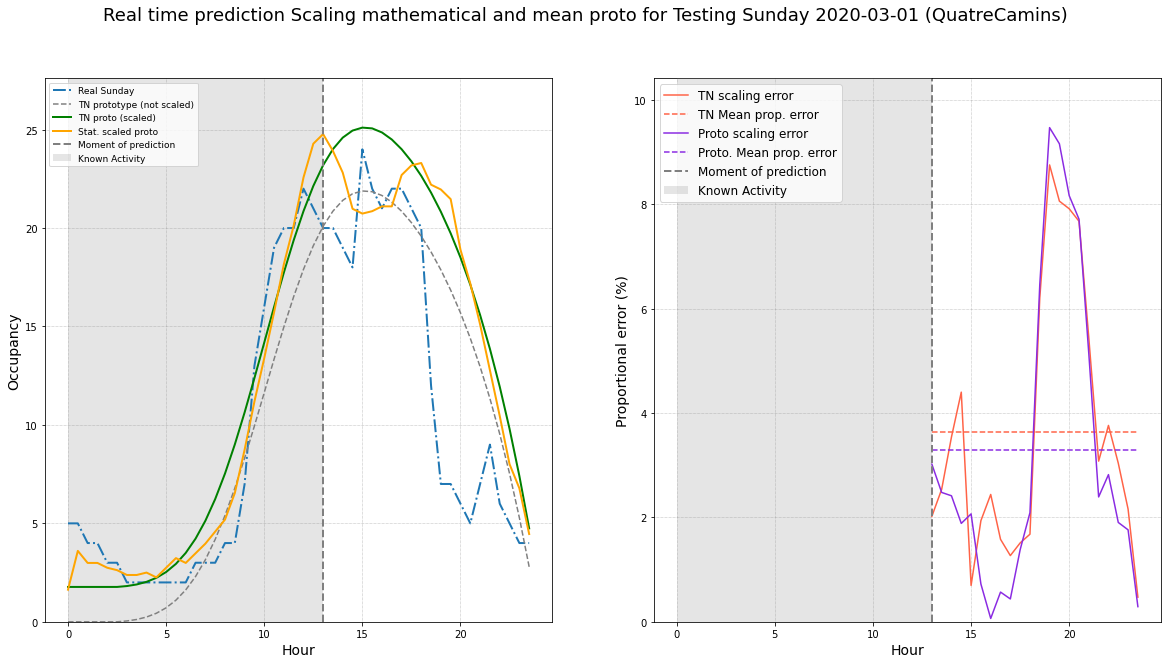

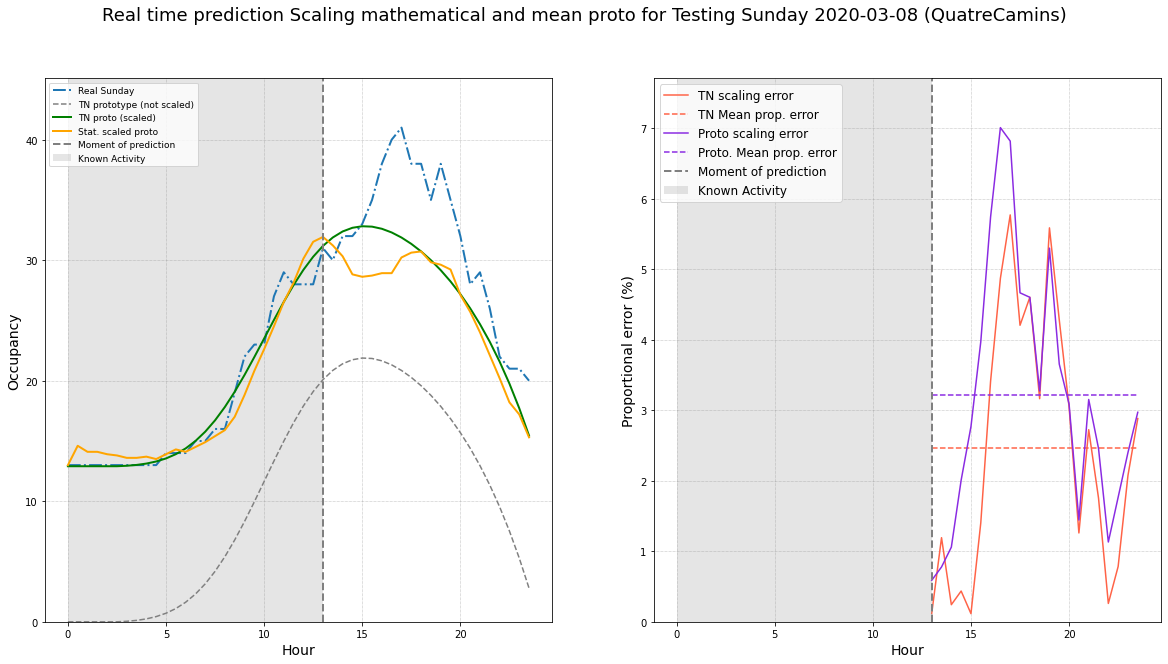

In [75]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

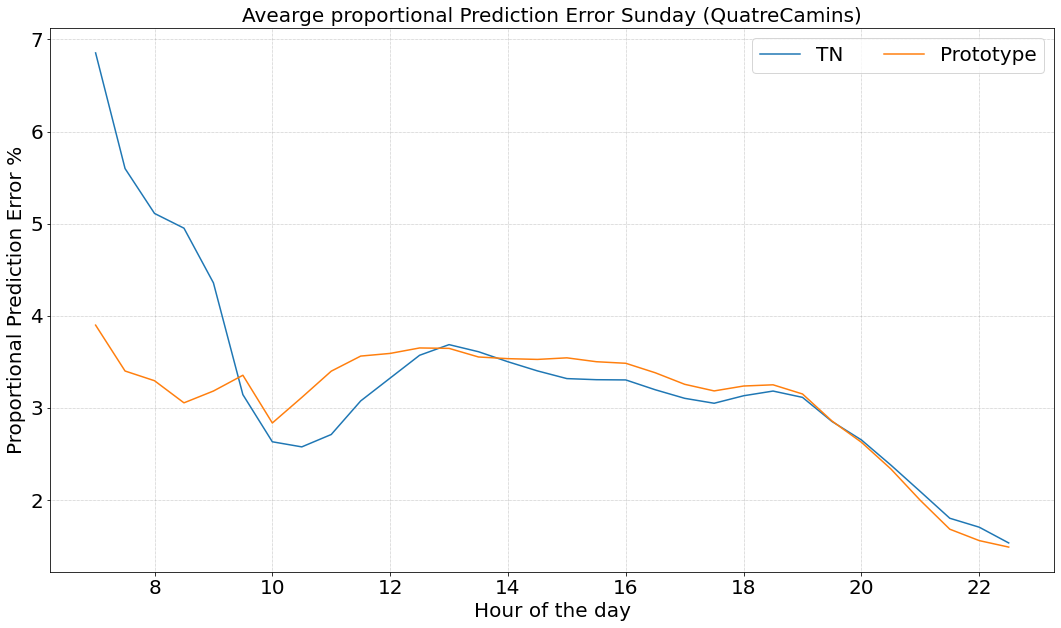

In [76]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [77]:
proto_running_error_we=np.concatenate((proto_running_error_we, proto_running_error_vec), axis=1)
tn_running_error_we=np.concatenate((tn_running_error_we, tn_running_error_vec), axis=1)

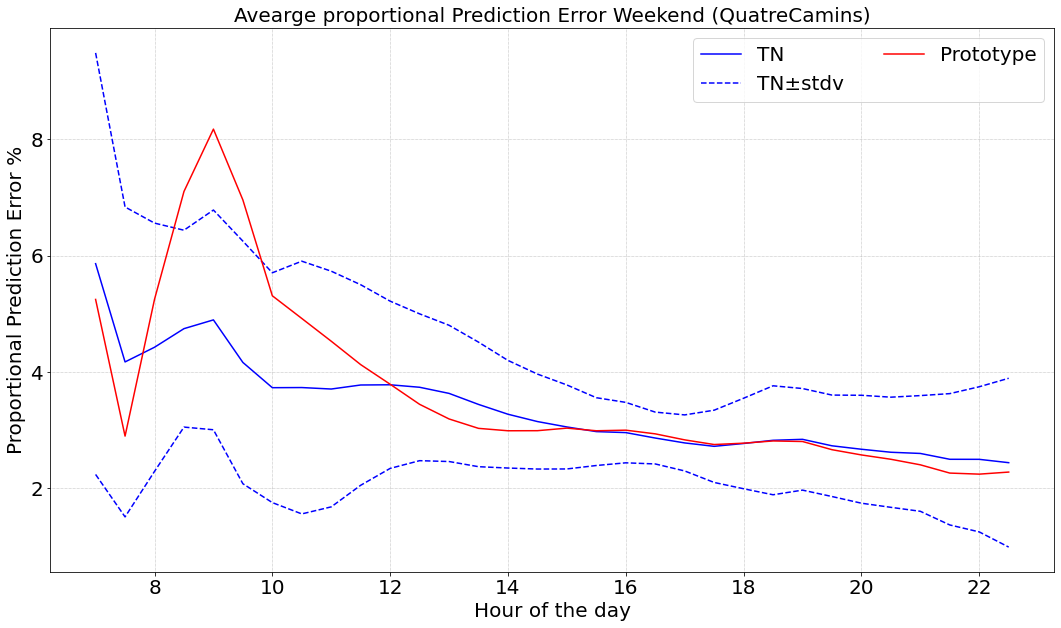

In [78]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_we,proto_running_error_we,starting_hour,"Weekend",current_parking)

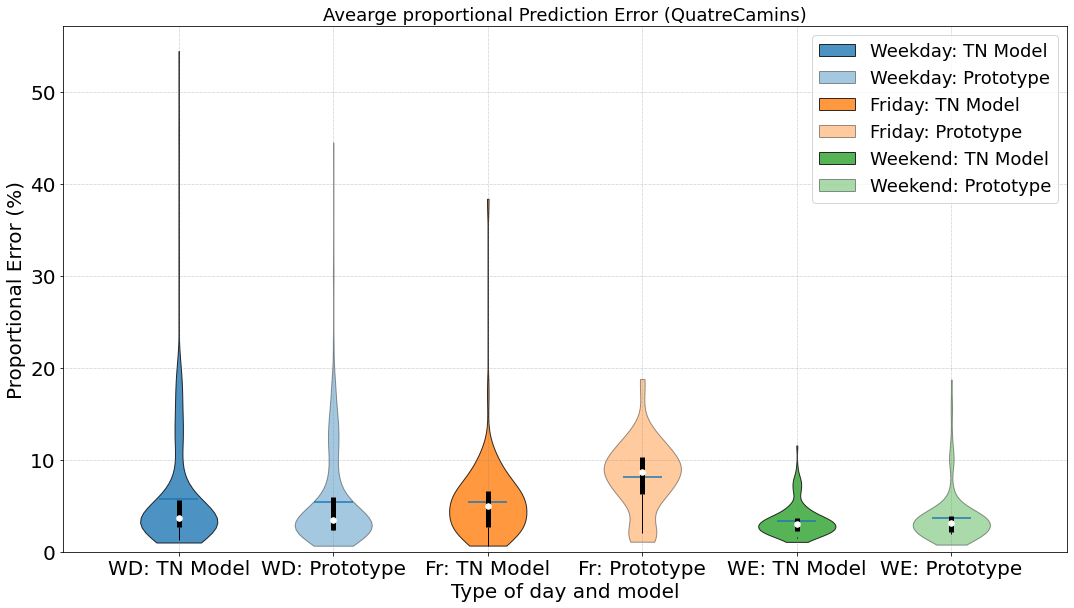

In [79]:
data = [tn_running_error_wd.flatten(),proto_running_error_wd.flatten(),
        tn_running_error_fr.flatten(),proto_running_error_fr.flatten(),
        tn_running_error_we.flatten(),proto_running_error_we.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Avearge proportional Prediction Error ("+ current_parking+')', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%2==0:
        pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-2)/2)])
        pc.set_alpha(.4)
    else:
        pc.set_facecolor(color_vec[int((cc-1)/2)])
        pc.set_alpha(.8)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),proto_running_error_wd.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),proto_running_error_fr.flatten()], [25, 50, 75], axis=1)
quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),proto_running_error_we.flatten()], [25, 50, 75], axis=1)

quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['WD: TN Model', 'WD: Prototype','Fr: TN Model', 'Fr: Prototype','WE: TN Model', 'WE: Prototype']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

ax2.legend(['Weekday: TN Model','Weekday: Prototype','Friday: TN Model','Friday: Prototype',
           'Weekend: TN Model','Weekend: Prototype'], fontsize=fsize)
#ax2.tick_params(axis='y', labelsize=20)
plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
fig.savefig('RunningPredictionError_'+current_parking+'_violinTH.pdf',bbox_inches='tight');

In [80]:
#figH=plotRunningPredcitionErrorAgg(tn_running_error_wd,proto_running_error_wd,tn_running_error_fr,
#                                  proto_running_error_fr,tn_running_error_we,proto_running_error_we,
#                                  starting_hour,current_parking,False)
#figH.savefig('RunningPredictionError_'+current_parking+'TH.pdf',bbox_inches='tight');

## Running  Prediction

In [81]:
day_indexes = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tn_proto_dict={}
tn_proto_dict["Monday"] = tn_weekday_nooff
tn_proto_dict["Tuesday"] = tn_weekday_nooff
tn_proto_dict["Wednesday"] = tn_weekday_nooff
tn_proto_dict["Thursday"] = tn_weekday_nooff
tn_proto_dict["Friday"] = tn_friday_nooff
tn_proto_dict["Saturday"] = tn1_weekend_nooff
tn_proto_dict["Sunday"] = tn1_weekend_nooff

tn_arr_proto_dict={}
tn_arr_proto_dict["Monday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Tuesday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Wednesday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Thursday"] = tn_arr_weekday_nooff
tn_arr_proto_dict["Friday"] = tn_arr_friday_nooff


tn_dep_proto_dict={}
tn_dep_proto_dict["Monday"] = tn_dep_weekday
tn_dep_proto_dict["Tuesday"] = tn_dep_weekday
tn_dep_proto_dict["Wednesday"] = tn_dep_weekday
tn_dep_proto_dict["Thursday"] = tn_dep_weekday
tn_dep_proto_dict["Friday"] = tn_dep_friday


t_days_dict={}
t_days_dict["Monday"] = testing_mondays
t_days_dict["Tuesday"] = testing_tuesdays
t_days_dict["Wednesday"] = testing_wednesdays
t_days_dict["Thursday"] = testing_thursdays
t_days_dict["Friday"] = testing_fridays
t_days_dict["Saturday"] = testing_saturdays
t_days_dict["Sunday"] = testing_sundays

hist_proto_dict={}
hist_proto_dict["Monday"] = hist_weekday_proto
hist_proto_dict["Tuesday"] = hist_weekday_proto
hist_proto_dict["Wednesday"] = hist_weekday_proto
hist_proto_dict["Thursday"] = hist_weekday_proto
hist_proto_dict["Friday"] = hist_friday_proto
hist_proto_dict["Saturday"] = hist_weekend_proto
hist_proto_dict["Sunday"] = hist_weekend_proto

#predWindow_vec=[0.5, 1, 1.5, 2, 2.5, 3] 
predWindow_vec=[1, 2, 3] 

pred_error_array=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])

proto_running_errorNOW_wd=[None] * len(predWindow_vec)
tn_running_errorNOW_wd=[None] *  len(predWindow_vec)
proto_running_errorNOW_fr=[None] * len(predWindow_vec)
tn_running_errorNOW_fr=[None] * len(predWindow_vec)
proto_running_errorNOW_we=[None] * len(predWindow_vec)
tn_running_errorNOW_we=[None] * len(predWindow_vec)


starting_hour=7
for i in range(0,len(day_indexes)):
    day=day_indexes[i]
    tn_proto=tn_proto_dict[day]
    t_days=t_days_dict[day]
    hist_proto=hist_proto_dict[day]
    j=0
    for pred_window in predWindow_vec:
        if day not in ['Saturday','Sunday']:
            
            tn_arr_proto = tn_arr_proto_dict[day]
            tn_dep_proto = tn_dep_proto_dict[day]
            [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNowTHv2(t_days,hist_proto,
                                                                            tn_arr_proto,tn_dep_proto,max_value,
                                                                            starting_hour,pred_window)
        else:
            [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_proto,
                                                                              tn_proto,max_value,starting_hour,pred_window)
        
        if day=='Monday':
            proto_running_errorNOW_wd[j]=proto_running_error_vec_now
            tn_running_errorNOW_wd[j]=tn_running_error_vec_now
        elif day in ['Tuesday','Wednesday','Thursday']:
            proto_running_errorNOW_wd[j]=np.concatenate((proto_running_errorNOW_wd[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_wd[j]=np.concatenate((tn_running_errorNOW_wd[j], tn_running_error_vec_now), axis=1)
        elif day == 'Friday':
            proto_running_errorNOW_fr[j]=proto_running_error_vec_now
            tn_running_errorNOW_fr[j]=tn_running_error_vec_now
        elif day == 'Saturday':
            proto_running_errorNOW_we[j]=proto_running_error_vec_now
            tn_running_errorNOW_we[j]=tn_running_error_vec_now
        else:
            proto_running_errorNOW_we[j]=np.concatenate((proto_running_errorNOW_we[j], proto_running_error_vec_now), axis=1)
            tn_running_errorNOW_we[j]=np.concatenate((tn_running_errorNOW_we[j], tn_running_error_vec_now), axis=1)
        
        
        
        pred_error_array[j,i]=np.mean(tn_running_error_vec_now)
        pred_error_array_proto[j,i]=np.mean(proto_running_error_vec_now)
        pred_error_array_stdv[j,i]=np.std(tn_running_error_vec_now)
        pred_error_array_proto_stdv[j,i]=np.std(tn_running_error_vec_now)
        
        j=j+1
        #plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

In [82]:
tn_running_error_wd=tn_running_errorNOW_wd[0]
tn_running_error_fr=tn_running_errorNOW_fr[0]
tn_running_error_we=tn_running_errorNOW_we[0]
proto_running_error_wd=proto_running_errorNOW_wd[0]
proto_running_error_fr=proto_running_errorNOW_fr[0]
proto_running_error_we=proto_running_errorNOW_we[0]

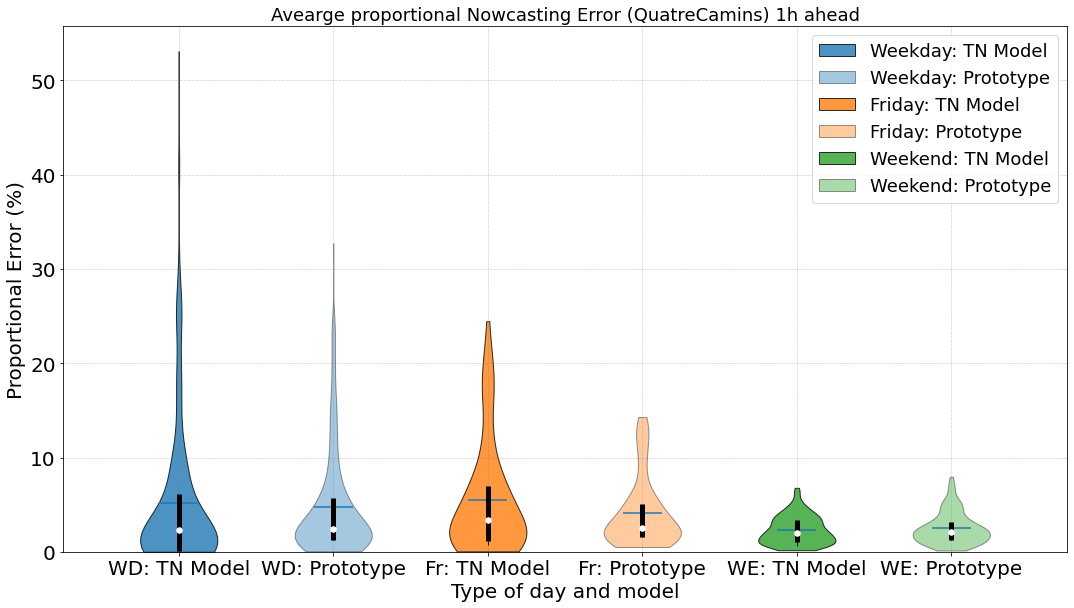

In [83]:
data = [tn_running_error_wd.flatten(),proto_running_error_wd.flatten(),
        tn_running_error_fr.flatten(),proto_running_error_fr.flatten(),
        tn_running_error_we.flatten(),proto_running_error_we.flatten()]

bd='#1f77b4'
rd='#ff7f0e'
gd='#2ca02c'
color_vec=[bd,rd,gd]
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), sharey=True)
#ax1.set_title('Default violin plot')
#ax1.set_ylabel('Observed values')
#ax1.violinplot(data)

ax2.set_title("Avearge proportional Nowcasting Error ("+ current_parking+') 1h ahead', fontsize=fsize)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=False,
        showextrema=False)

cc=0
for pc in parts['bodies']:
    cc=cc+1
    if cc%2==0:
        pc.set_facecolor('#D43F3A')
        pc.set_facecolor(color_vec[int((cc-2)/2)])
        pc.set_alpha(.4)
    else:
        pc.set_facecolor(color_vec[int((cc-1)/2)])
        pc.set_alpha(.8)
    pc.set_edgecolor('black')


quartile1wd, medianswd, quartile3wd = np.percentile([tn_running_error_wd.flatten(),proto_running_error_wd.flatten()], [25, 50, 75], axis=1)
quartile1fr, mediansfr, quartile3fr = np.percentile([tn_running_error_fr.flatten(),proto_running_error_fr.flatten()], [25, 50, 75], axis=1)
quartile1we, medianswe, quartile3we = np.percentile([tn_running_error_we.flatten(),proto_running_error_we.flatten()], [25, 50, 75], axis=1)

quartile1=np.concatenate((quartile1wd, quartile1fr,quartile1we), axis=0)
medians=np.concatenate((medianswd, mediansfr,medianswe), axis=0)
quartile3=np.concatenate((quartile3wd, quartile3fr,quartile3we), axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['WD: TN Model', 'WD: Prototype','Fr: TN Model', 'Fr: Prototype','WE: TN Model', 'WE: Prototype']
#for ax in [ax1, ax2]:
set_axis_style(ax2, labels)

ax2.legend(['Weekday: TN Model','Weekday: Prototype','Friday: TN Model','Friday: Prototype',
           'Weekend: TN Model','Weekend: Prototype'], fontsize=fsize)
#ax2.tick_params(axis='y', labelsize=20)
plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()
fig.savefig('RunningPredictionError_'+current_parking+'_violin_NOW1h_TH.pdf',bbox_inches='tight');

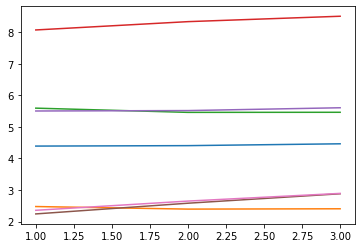

In [84]:
plt.plot(predWindow_vec,pred_error_array)


In [85]:
m_row_runPred=[current_parking,'meanE_tn'] + pred_error_array[0,].tolist()
s_row_runPred=[current_parking,'mStdvE_tn'] + pred_error_array_stdv[0,].tolist()
m_row_runPred_proto=[current_parking,'meanE_proto'] + pred_error_array_proto[0,].tolist()
s_row_runPred_proto=[current_parking,'mStdvE_proto'] + pred_error_array_proto_stdv[0,].tolist()



In [86]:
f = open('data/'+current_parking+'_runnError_1hTH.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row_runPred)
writer.writerow(s_row_runPred)
writer.writerow(m_row_runPred_proto)
writer.writerow(s_row_runPred_proto)

# close the file
f.close()